# Investigate models - feature sensitivity analysis, interpretability

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import time
import dill
import json
import os

from scipy.stats import pearsonr, spearmanr
import scipy.cluster.hierarchy as shc

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from sklearn import metrics as skmetrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import AgglomerativeClustering

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from captum import attr

import plotly.graph_objects as go
import plotly.express as px

In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotl

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, Results, Model, ModelWithAutoencoders, ModelAnalysis
import architectures

In [9]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/"

 codes-all_features_spearman_corr_matrix.csv  'GSEA Preranked Top 1000 genes'


In [10]:
fpath = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/"
mat = pd.read_csv(os.path.join(fpath, "codes-all_features_spearman_corr_matrix.csv"))
print(mat.shape)
mat.head()

(17419, 11)


,Gene name,0,1,2,3,4,5,6,7,8,9
0,TSPAN6,0.033787,-0.149198,0.145456,-0.556589,-0.043076,0.122816,-0.016845,0.069315,0.018161,0.082024
1,TNMD,-0.084530,-0.004540,-0.024192,0.174575,-0.147462,0.029535,-0.031523,0.002212,0.018718,-0.153287
2,DPM1,0.194301,0.129896,0.030176,-0.185366,0.055385,0.157262,-0.015808,0.064380,0.025963,0.100453
3,SCYL3,0.353670,-0.191941,-0.002433,0.262228,-0.385722,0.072364,-0.042708,0.046739,-0.094541,-0.052162
4,C1orf112,0.193592,0.210496,0.272056,0.188792,-0.158848,-0.079223,0.005508,-0.003991,0.384441,0.208711


## Load and preprocess data

In [3]:
! ls "../../Data/Preprocessed Datasets/"

CCLE-GDSC-KINOMEscan_drugs_and_cell_lines_basic_intersection.pkl
gdsc_drugs_targets_features.csv
GDSC-KINOMEscan_proteins_intersection_dataset.pkl
GDSC-KINOMEscan_proteins_intersection_+_L1000_genes_dataset.pkl
GDSC-KINOMEscan_proteins_intersection_+_L1000_genes_dataset_+_remaining_targets.pkl
GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset.pkl
GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset_with_IC50.pkl
GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_+_signatures_dataset.pkl
merck_signatures_preprocessed_dataframe.csv


In [103]:
# Load dataset
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset_with_IC50.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)
print(full_dataset.full_cell_lines_data.shape, full_dataset.drugs_data.shape)

Kinases Dataset + Remaning GDSC drug's putative targets <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset.
Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
nmutations in 18 genes.
In addition, expressions and mutations (17 new features) of remaining target genes from GDSC are included
Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered.
(922, 242) (74, 294)


In [104]:
# Establish response metric
global_response_metric = "LN_IC50"
split_seeds_all = [40, 65, 31, 9, 27]

In [105]:
# Preprocess
# Establish response data for samples (drug-cell line pairs)
general_response_df = full_dataset.response_data.copy()

# Establish cell line features data
cell_line_data_original_df = full_dataset.full_cell_lines_data.copy()

# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in general_response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_original_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_original_df.index = cell_line_data_original_df.cell_line_id
cell_line_data_original_df = cell_line_data_original_df.drop("cell_line_id", axis=1)

# Extract response only for cell lines for which features are present
general_response_df = general_response_df[~general_response_df.COSMIC_ID.isin(missing_cell_lines)]

# Establish drug features data
drug_data_original_df = full_dataset.drugs_data.copy()

# Convert drug index from LINCS name to GDSC drug ID
drug_data_original_df.index = drug_data_original_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)

# Establish how many cells go to train/val/test sets
num_val_cell_lines = 100
num_test_cell_lines = 100

In [106]:
# Preprocess whole data for interpretability analysis purposes
global_response_metric = "LN_IC50"
# Create a set of all available samples
samples_all = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]
# Scale the response variable if needed
samples_all[global_response_metric] = Dataset.min_max_series(samples_all[global_response_metric])
# Normalize the drug and cell line data
cols_subset = [col for col in list(cell_line_data_original_df) if col.endswith("_exp")]
cell_line_data_df = Dataset.standardize_data(cell_line_data_original_df, cols_subset=cols_subset)
# Drug data
drug_data_df = Dataset.standardize_data(drug_data_original_df)
print(samples_all.shape, cell_line_data_df.shape, drug_data_df.shape)

/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(52730, 3) (922, 241) (74, 294)


## Comparison of attribution methods from Captum

#### Attributions method widget - model retrained on the whole data

In [16]:
! ls "../Final results/Models retrained on the whole data/"

'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2 - replay'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay'


In [17]:
models_directories = "../Final results/Models retrained on the whole data/"
print(models_directories)

../Final results/Models retrained on the whole data/


In [19]:
def attribution_analysis_widget(experiment, model, dependence_penalty, drug_name, attr_method, 
                                normalize_feat_imp, k_important_feats,
                                feature_type, display_response_vs_feat):
    # Establish directory where the trained model is stored
    model_dir = os.path.join(models_directories, experiment, model + ".pkl")
    # Get drug GDSC ID
    drug_id = full_dataset.gdsc_name_to_gdsc_id_mapper[drug_name]
    # Load the model
    with open(model_dir, "rb") as f:
        model = dill.load(f)
    network = model.network
    network.eval()
    # Analyze whole rec system
    def net(drug_input, cl_input):
        return network(drug_input, cl_input)[0]
    
    # Establish method for calculating the gradients
    if attr_method == "Integrated Gradients":
        method = attr.IntegratedGradients(net)
    if attr_method == "Saliency":
        method = attr.Saliency(net)
    if attr_method == "Input X Gradient":
        method = attr.InputXGradient(net)
    if attr_method == "Feature Ablation":
        method = attr.FeatureAblation(net)
    if attr_method == "Feature Permutation":
        method = attr.FeaturePermutation(net)
    if attr_method == "Shapley Value Sampling":
        method = attr.ShapleyValueSampling(net)
    # Establish samples on which to compute importances
    samples  = samples_all[samples_all["DRUG_ID"] == drug_id]
    cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
    drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()
    cl_input.requires_grad_()
    drug_input.requires_grad_()
    
    # Compute atttributions
    attributions = method.attribute(inputs=(drug_input, cl_input))
    
    drug_attributions, cl_attributions = attributions
    drug_attributions = drug_attributions.detach().numpy()
    cl_attributions = cl_attributions.detach().numpy()
    drug_attributions = np.mean(drug_attributions, axis=0)
    cl_attributions = np.mean(cl_attributions, axis=0)
    if normalize_feat_imp:
        drug_attributions = drug_attributions / np.abs(drug_attributions).sum()
        cl_attributions = cl_attributions / np.abs(cl_attributions).sum()
    drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
    cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

    all_features_attributions = drug_attributions + cl_attributions
    # Sort by importance
    drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
    cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

    # Plot k most important drug or cell line features
    if feature_type == "cell line":
        plt.figure()
        sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
        plt.title("{} feature importances: {}".format("Cell line", drug_name))
        plt.xticks(rotation=90, fontsize=8)
    elif feature_type == "both":
        plt.figure()
        plt.title("{} feature importances: {}".format("Cell line", drug_name))
        sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
        plt.xticks(rotation=90, fontsize=8)

        plt.figure()
        plt.title("{} feature importances: {}".format("Drug", drug_name))
        sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
        plt.xticks(rotation=90, fontsize=8)
    else:
        plt.figure()
        sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
        plt.title("{} feature importances: {}".format("Drug", drug_name))
        plt.xticks(rotation=90, fontsize=8)

    if display_response_vs_feat:
        response_predictions = net(drug_input, cl_input)
        true_response = samples[global_response_metric]
        def plot_response_vs_feat(feature, response):
            x = cell_line_data_original_df.loc[samples["COSMIC_ID"].values][feature]
            if response == "predicted":
                y = response_predictions.detach().numpy().reshape(-1)
            else:
                y = true_response
            plt.figure()
            sns.regplot(x, y)
            plt.title("Response vs {}".format(feature))
            plt.xlabel(feature)
            plt.ylabel(global_response_metric)
        interact(plot_response_vs_feat,
        feature=[x[0] for x in cl_attributions[:k_important_feats]] + ["BRAF_mut"],
        response=["predicted", "true"])
            
attribution_analysis_widget_result = interactive(attribution_analysis_widget,
            experiment=os.listdir(models_directories),
            model=["retrained_model", "retrained_model_without_independence_loss", "retrained_model_all_cl_feats_scaled",
                  "retrained_model_without_augmentation"],
            dependence_penalty=[True, False],
            drug_name=[x for x in full_dataset.gdsc_name_to_gdsc_id_mapper.keys()],
            attr_method=["Integrated Gradients", "Saliency", "Input X Gradient", "Feature Ablation",
                        "Feature Permutation", "Shapley Value Sampling"],
            normalize_feat_imp=[False, True],
            k_important_feats=widgets.IntSlider(value=10, min=1, max=30,step=1),
            feature_type=["cell line", "drug", "both"],
            display_response_vs_feat=[False, True])

display(attribution_analysis_widget_result)

interactive(children=(Dropdown(description='experiment', options=('One-layer autoencoders, two-layer code forw…

#### Comparisons of attribtion methods on synthetic data

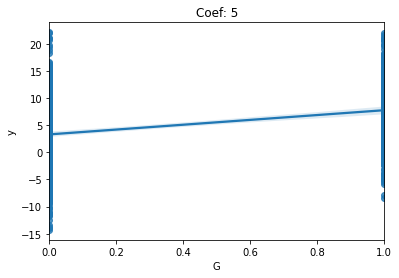

,A,B,C,D,E,F,G,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.001575,0.023805,0.012562,-0.080565,0.017431,0.300000,0.300000,4.633117
std,1.002277,0.977614,0.988058,0.967054,0.971117,0.458487,0.458487,6.859790
min,-2.912382,-2.804733,-3.266493,-3.233923,-3.015533,0.000000,0.000000,-14.295541
25%,-0.637509,-0.649815,-0.658766,-0.713034,-0.668334,0.000000,0.000000,-0.139316
50%,0.012367,0.027072,0.012105,-0.093624,0.029285,0.000000,0.000000,4.926361
75%,0.656810,0.681166,0.653105,0.548280,0.708376,1.000000,1.000000,9.455697
max,4.149783,3.707923,3.282136,3.402747,2.839423,1.000000,1.000000,22.109691


In [68]:
from pandas.plotting import scatter_matrix
# Create synthetic data
def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr
N = 1000
x1 = np.random.normal(0, 1, N)
x2 = np.random.normal(0, 1, N)
x3 = np.random.normal(0, 1, N)
x4 = np.random.normal(0, 1, N)
x5 = np.random.normal(0, 1, N)
x6 = rand_bin_array(300, N)
x7 = rand_bin_array(300, N)
intercept = 3
y_noise = np.random.normal(0, 0.5, N)
standardize_binary_variables = False
scale_target_variable = False

# Create response variable
coefs = np.array([3, 1, 0, 0, 6, 0, 5])
y = coefs[0] * x1 + coefs[1] * x2 + coefs[2] * x3 + coefs[3] * x4 + coefs[4] * x5 + coefs[5] * x6 + coefs[6] * x7 + intercept 
data = pd.DataFrame({"A": x1, "B": x2, "C": x3, "D": x4, "E": x5, "F": x6, "G": x7, "y": y})

# Scale binary values if specified
if standardize_binary_variables:
    data["F"] = (data["F"] - data["F"].mean()) / data["F"].std()
    data["G"] = (data["G"] - data["G"].mean()) / data["G"].std()
if scale_target_variable:
    data["y"] = (data["y"] - data["y"].min()) / (data["y"].max() - data["y"].min())

y_train = data["y"].values.reshape(-1, 1)
X_train = data.drop("y", axis=1).values
# Plot y w.r.t. x
index = 6
plt.title("Coef: {}".format(coefs[index]))
sns.regplot(data.iloc[:, index], data["y"])
plt.show()
data.describe()

In [69]:
# Create linear regression model in PyTorch and apply several attribution methods
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        out = self.linear(x)
        return out

In [70]:
input_dim = X_train.shape[1] 
output_dim = 1    
learning_rate = 0.01 
epochs = 200

network = LinearRegression(input_dim, output_dim)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

In [71]:
for epoch in range(epochs):
    # Converting inputs and labels to Variable
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())
    optimizer.zero_grad()
    # Get output from the model, given the inputs
    outputs = network(inputs)

    # Get loss for the predicted output
    loss = criterion(outputs, labels)
    # Get gradients w.r.t to parameters
    loss.backward()

    # Update parameters
    optimizer.step()

    print('Epoch {}, loss {}'.format(epoch, loss.item()))

Epoch 0, loss 72.31522369384766
Epoch 1, loss 69.46311950683594
Epoch 2, loss 66.72969055175781
Epoch 3, loss 64.1098861694336
Epoch 4, loss 61.59885787963867
Epoch 5, loss 59.19197082519531
Epoch 6, loss 56.88479995727539
Epoch 7, loss 54.6731071472168
Epoch 8, loss 52.552825927734375
Epoch 9, loss 50.52007293701172
Epoch 10, loss 48.571163177490234
Epoch 11, loss 46.7025146484375
Epoch 12, loss 44.91075134277344
Epoch 13, loss 43.19260025024414
Epoch 14, loss 41.54495620727539
Epoch 15, loss 39.96485900878906
Epoch 16, loss 38.44944763183594
Epoch 17, loss 36.99598693847656
Epoch 18, loss 35.60188293457031
Epoch 19, loss 34.26462936401367
Epoch 20, loss 32.981834411621094
Epoch 21, loss 31.75120735168457
Epoch 22, loss 30.570573806762695
Epoch 23, loss 29.437822341918945
Epoch 24, loss 28.350961685180664
Epoch 25, loss 27.30805206298828
Epoch 26, loss 26.307273864746094
Epoch 27, loss 25.346860885620117
Epoch 28, loss 24.425125122070312
Epoch 29, loss 23.540456771850586
Epoch 30, los

torch.Size([1000, 1])
Inherent standard deviation in true y: 6.8563592800169655
RMSE and correlation between true and predicted y: 0.9026874689267607 (0.9925107945905398, 0.0)


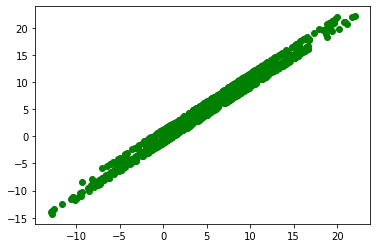

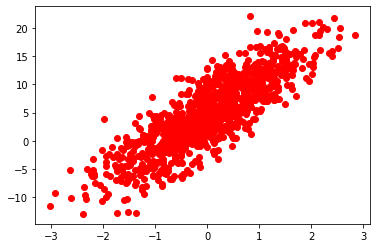

In [72]:
with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = network(Variable(torch.from_numpy(X_train).float()))
print(predicted.shape)
print("Inherent standard deviation in true y:", y_train.std())
print("RMSE and correlation between true and predicted y:", 
      skmetrics.mean_squared_error(y_train.reshape(-1), predicted.numpy().reshape(-1)) ** 0.5,
      pearsonr(y_train.reshape(-1), predicted.numpy().reshape(-1)))

plt.figure()
plt.plot(predicted, y_train, "go")
plt.figure()
plt.plot(X_train[:, coefs.argmax()], predicted, "ro")

plt.show()

In [73]:
# Apply feature attribution methods
def feat_attr_widget(attr_method):
    if attr_method == "Integrated Gradients":
        method = attr.IntegratedGradients(network)
    if attr_method == "Saliency":
        method = attr.Saliency(network)
    if attr_method == "Input X Gradient":
        method = attr.InputXGradient(network)
    if attr_method == "Feature Ablation":
        method = attr.FeatureAblation(network)
    if attr_method == "Feature Permutation":
        method = attr.FeaturePermutation(network)
    if attr_method == "Shapley Value Sampling":
        method = attr.ShapleyValueSampling(network)
    # Compute atttributions
    net_input = Variable(torch.from_numpy(X_train).float())
    net_input.requires_grad_()
    attributions = method.attribute(inputs=net_input)
    raw_attributions = attributions.detach().numpy()
    attributions = np.mean(raw_attributions, axis=0)
    # Connect attributions with feature names
    attributions = [(x, y) for x, y in zip(data.columns[:-1], attributions)]
    attributions = sorted(attributions, key=lambda x: abs(x[1]), reverse=True)
    print("Features and corresponding true coefficents:")
    for i in range(len(coefs)):
        print(list(data)[i], coefs[i])
    # Plot the attributions
    plt.figure(figsize=(4, 4))
    sns.barplot([x[0] for x in attributions], [x[1] for x in attributions])
    plt.show()
    return raw_attributions
    
    
feat_attr_widget_result = interactive(feat_attr_widget,
        attr_method=["Integrated Gradients", "Saliency", "Input X Gradient", "Feature Ablation",
                        "Feature Permutation", "Shapley Value Sampling"])
display(feat_attr_widget_result)

interactive(children=(Dropdown(description='attr_method', options=('Integrated Gradients', 'Saliency', 'Input …

## Analysis of code-features relationship using system's autoencoders

#### Code-features correlation analysis widget

In [22]:
! ls "../Final results/Models retrained on the whole data/"

'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2 - replay'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay'


In [23]:
models_directories = "../Final results/Models retrained on the whole data/"

In [28]:
def autoencoder_feat_codes_analysis_widget(experiment, model, entities, autoencoder_part, corr_metric,
                                           absolute_corr, display_cov_mat, absolute_covs):
    # Establish directory where the trained model is stored
    model_dir = os.path.join(models_directories, experiment, model + ".pkl")
    # Load the model
    with open(model_dir, "rb") as f:
        model = dill.load(f)
    network = model.network
    network.eval()
    # Establish input data
    if entities == "cell lines":
        index = cell_line_data_df.columns
        input_data = cell_line_data_df.values
        autoencoder = network.cell_line_autoencoder
    if entities == "drugs":
        index = drug_data_df.columns
        input_data = drug_data_df.values
        autoencoder = network.drug_autoencoder
    # Pass the data into autoencoder
    codes, recs = autoencoder(torch.from_numpy(input_data).float())
    codes = codes.detach().numpy()
    recs = recs.detach().numpy()
    # Intialize resulting correlation matrix
    corr_mat = np.zeros((input_data.shape[1], codes.shape[1]))
    for code_dim in range(codes.shape[1]):
        for feat_dim in range(input_data.shape[1]):
            code_values = codes[:, code_dim]
            if autoencoder_part == "encoder":
                feat_values = input_data[:, feat_dim]
            else:
                feat_values = recs[:, feat_dim]
            # Calculate correlation
            if corr_metric == "pearson":
                r = pearsonr(code_values, feat_values)[0]
            if corr_metric == "spearman":
                r = spearmanr(code_values, feat_values)[0]
            # Put correlation coefficient into proper entry in the resulting matrix
            corr_mat[feat_dim, code_dim] = r
    # Take absolute value if specified
    if absolute_corr:
        corr_mat = np.abs(corr_mat)
    # Normalize the resulting matrix
    #corr_mat = normalize(corr_mat)
    # Wrap the matrix with DataFrame
    corr_mat_df = pd.DataFrame(corr_mat, index=index, 
                          columns=range(10))
    # Hierarchical clustering of the corr matrix - assign to clusters
    num_clusters = 10
    cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
    assignments = cluster.fit_predict(corr_mat_df)
    corr_mat_df["cluster_assignment"] = assignments
    # Create a dictionary mapping each cluster assignmnet to color
    palette = sns.color_palette(n_colors=num_clusters)
    entity_color_map = {}
    for entity, assign in zip(corr_mat_df.index, corr_mat_df.cluster_assignment):
        entity_color_map[entity] = palette[assign]
    # Plot the clustermap
    cmap = sns.diverging_palette(h_neg=12, h_pos=127, s=100, l=50, sep=50, n=9, as_cmap=False)
    grid = sns.clustermap(corr_mat_df.drop("cluster_assignment", axis=1), method="ward", metric="euclidean",
                      figsize=(6, 8), col_cluster=True,
                      row_colors=[entity_color_map[x] for x in corr_mat_df.index], yticklabels=3,
                      cmap=cmap, cbar_kws={"ticks":[-0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75]})
    # Change plotting params
    grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_ymajorticklabels(), fontsize=5)
    # Color the yticks by cluster assignment
    for ytick in grid.ax_heatmap.get_yticklabels():
        color = entity_color_map[ytick._text]
        ytick.set_color(color)
    # Plot the covariance matrix if specified
    if display_cov_mat:
        codes_cov_mat = np.cov(codes, rowvar=False)
        if absolute_covs:
            codes_cov_mat = np.abs(codes_cov_mat)
        sns.set(font_scale=1.1)
        plt.figure(figsize=(5, 4))
        plt.title("{} covariance matrix".format(entities))
        ax = sns.heatmap(codes_cov_mat, annot=False)
        ax.tick_params(labelsize=10)
    
    plt.show()
    return corr_mat_df, codes, entity_color_map
          

autoencoder_feat_codes_analysis_widget_result = interactive(autoencoder_feat_codes_analysis_widget,
            experiment=os.listdir(models_directories),
            model=["retrained_model", "retrained_model_without_independence_penalty", "retrained_model_all_cl_feats_scaled"],
            entities=["cell lines", "drugs"],
            autoencoder_part=["encoder", "decoder"],
            corr_metric=["pearson", "spearman"],
            absolute_corr=[False, True],
            display_cov_mat=[False, True],
            absolute_covs=[True, False])

display(autoencoder_feat_codes_analysis_widget_result)

interactive(children=(Dropdown(description='experiment', options=('One-layer autoencoders, two-layer code forw…

#### Choosing color palette

In [121]:
sns.choose_diverging_palette(as_cmap=False)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43026136111758173, 0.6200066482697917, 0.6787801878373952),
 (0.6085255804707219, 0.7412795877319109, 0.7824000973141302),
 (0.786789799823862, 0.86255252719403, 0.8860200067908652),
 (0.95, 0.95, 0.95),
 (0.954577257933482, 0.7665309859226215, 0.7803256889894359),
 (0.9197182699854205, 0.5873587656270927, 0.6117400023569117),
 (0.884859282037359, 0.40818654533156384, 0.4431543157243877),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

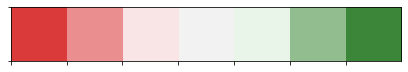

In [126]:
sns.palplot(sns.diverging_palette(h_neg=12, h_pos=127, s=75, l=50, sep=80, n=7))

In [127]:
cmap = sns.diverging_palette(h_neg=12, h_pos=127, s=75, l=50, sep=50, as_cmap=True)
print(type(cmap))

<class 'matplotlib.colors.LinearSegmentedColormap'>


#### Create tables with ranked list of genes based on correlation between input/reconstructed features and code dimensions

In [8]:
! ls "../Final results/Models retrained on the whole data/"

'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2 - replay'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay'


In [9]:
models_directories = "../Final results/Models retrained on the whole data/"

In [10]:
# Example table of corss vs. input features
experiment = "One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2"
model = "retrained_model"
entities = "cell lines"
inputs = cell_line_data_df
autoencoder_part = "encoder"
corr_metric = "pearson"
absolute_corr = False


df = ModelWithAutoencoders.features_codes_corr_ranked_lists(models_directories, experiment, model, entities,
                                                            inputs, autoencoder_part, corr_metric, 
                                                            absolute_corr, filename="test2.csv")
print(df.shape)
df.tail()

(241, 10)


,0,1,2,3,4,5,6,7,8,9
Tissue_thyroid,0.033149,-0.001053,-0.032652,-0.092159,-0.060232,0.070842,-0.070396,-0.031715,-0.048737,0.085484
Tissue_urogenital_system,0.172225,0.033691,0.079110,0.057598,-0.152591,-0.084939,0.102528,-0.114774,-0.037032,-0.116236
ATM_mut,0.019737,-0.022989,0.059504,-0.008313,-0.010090,0.064259,0.021400,-0.016641,-0.066074,-0.018500
CHEK2_mut,-0.051485,0.017580,0.032246,0.022122,-0.004807,0.005219,-0.018685,-0.048452,-0.036210,-0.048761
NTRK2_mut,0.013778,0.013770,-0.059422,-0.012015,-0.021871,0.106303,-0.009405,-0.000484,-0.052958,-0.029639


Model: retrained_model
encoder, pearson
Mean: 0.00, median: 0.00, std: 0.17, min: -0.69, max: 0.69
encoder, spearman
Mean: 0.00, median: 0.00, std: 0.16, min: -0.76, max: 0.58
decoder, pearson
Mean: 0.01, median: 0.01, std: 0.23, min: -0.80, max: 0.80
decoder, spearman
Mean: 0.01, median: 0.01, std: 0.22, min: -0.83, max: 0.70



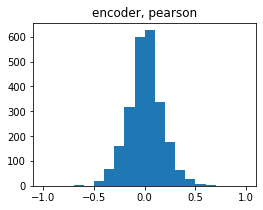

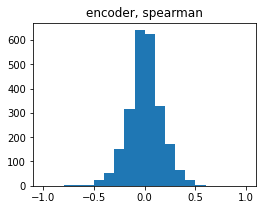

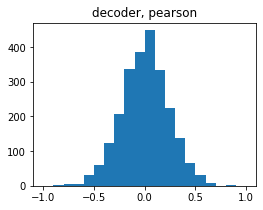

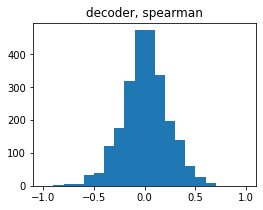

In [47]:
# Check statistics of corelations in different models
experiment = "One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"
inputs = cell_line_data_df.copy()
entities = "cell lines"
absolute_corr = False
# models = ["retrained_model", "retrained_model_all_cl_feats_scaled", "retrained_without_augmentation", 
#           "retrained_without_independence_loss"]
models = ["retrained_model"]
corr_metrics = ["pearson", "spearman"]
autoencoder_parts = ["encoder", "decoder"]

plot_hists = True
for model in models:
    print("Model:", model)
    for autoencoder_part in autoencoder_parts:
        for corr_metric in corr_metrics:
            corr_df = ModelWithAutoencoders.features_codes_corr_ranked_lists(models_directories, experiment, model, entities,
                                                            inputs, autoencoder_part, corr_metric, 
                                                            absolute_corr, filename=None)
            print("{}, {}".format(autoencoder_part, corr_metric))
            print("Mean: {:.2f}, median: {:.2f}, std: {:.2f}, min: {:.2f}, max: {:.2f}".format(
            corr_df.values.flatten().mean(), np.median(corr_df.values.flatten()), corr_df.values.flatten().std(),
            corr_df.values.flatten().min(), corr_df.values.flatten().max()))
            if plot_hists:
                plt.figure(figsize=(4, 3))
                plt.title("{}, {}".format(autoencoder_part, corr_metric))
                plt.hist(corr_df.values.flatten(), bins=np.arange(-1, 1.1, 0.1))
    print()
    
plt.show()

#### Create final ranked lists to perform gene enrichment analysis on

In [8]:
models_directories = "../Final results/Models retrained on the whole data/"
experiment = "One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"
model = "retrained_model"
entities = "drugs"
inputs = drug_data_df.copy()
autoencoder_part = "decoder"
corr_metric = "spearman"
absolute_corr = False
filename = "drugs_decoder_spearman_features_code_space_correlations.csv"

corr_df = ModelWithAutoencoders.features_codes_corr_ranked_lists(models_directories, experiment, model, entities,
                                                            inputs, autoencoder_part, corr_metric, 
                                                            absolute_corr, filename=filename)
print(corr_df.shape)
corr_df.tail()

(294, 10)


,0,1,2,3,4,5,6,7,8,9
Protein,,,,,,,,,,
KPCD3,-0.211077,0.214276,0.180244,0.129893,0.012070,-0.355765,0.114906,-0.095683,-0.226479,-0.196209
FGFR3,-0.050900,0.098023,0.305768,-0.233469,-0.434876,-0.286990,-0.279408,-0.131314,0.071425,-0.054839
ACVR1,-0.036564,0.127671,0.210041,-0.015357,0.017549,-0.401496,0.041333,-0.246087,-0.274935,-0.016512
GSK3A,0.019474,-0.244073,0.010174,0.351825,0.024569,-0.412780,0.284887,0.159245,-0.268212,0.060052
KPCD,0.073143,-0.021962,0.021548,-0.137238,-0.021281,-0.222273,0.163302,0.145709,-0.188804,0.067990


In [9]:
print("Mean: {:.2f}, median: {:.2f}, std: {:.2f}, min: {:.2f}, max: {:.2f}".format(
corr_df.values.flatten().mean(), np.median(corr_df.values.flatten()), corr_df.values.flatten().std(),
corr_df.values.flatten().min(), corr_df.values.flatten().max()))

Mean: -0.06, median: -0.06, std: 0.22, min: -0.67, max: 0.54


## Create tables of correlation between all expression features (outside of input data) and hidden dimension of the encoder

#### Preprocess the original gene expression matrix from GDSC

In [16]:
! ls "../../Data/GDSC/Cell Line Data/"

 Cell_line_RMA_proc_basalExp.txt
 Cell_line_RMA_proc_basalExp.txt.zip
 cell_lines_coding_variants_preprocessed_DataFrame.csv
 cell_lines_gene_expression_preprocessed_DataFrame.csv
 cell_lines_tissue_preprocessed_DataFrame.csv
'PANCANCER_Genetic_feature_variant_Fri Nov  8 14_17_05 2019.csv'
 README.txt


In [145]:
# Load gene expression data from GDSC and preprocess
filepath = "../../Data/GDSC/Cell Line Data/"
gene_exp_original_df = pd.read_csv(os.path.join(filepath,  "Cell_line_RMA_proc_basalExp.txt"), sep="\t")
# Drop the gene title column and rows where gene symbol is missing
gene_exp_droped_nan_symbols_df = gene_exp_original_df.drop("GENE_title", axis=1).dropna(subset=["GENE_SYMBOLS"])
# Put gene symbol as an index of the DataFrame
gene_exp_symbols_as_index_df = gene_exp_droped_nan_symbols.copy()
gene_exp_symbols_as_index_df.index = gene_exp_symbols_as_index_df["GENE_SYMBOLS"]
# Drop the gene symbol column
gene_exp_symbols_as_index_df = gene_exp_symbols_as_index_df.drop("GENE_SYMBOLS", axis=1)
# Keep just the columns (cell lines) whith integer IDs
cols_to_keep = []
for col in gene_exp_symbols_as_index_df.columns:
    if "." not in col[5:]:
        cols_to_keep.append(col)
gene_exp_symbols_as_index_df = gene_exp_symbols_as_index_df[cols_to_keep]
# Transpose the gene expression matrix so that cell line are in columns
gene_exp_transposed_df = gene_exp_symbols_as_index_df.transpose()
# Map the index to just integer ID
def mapper(s):
    return int(s[5:])
gene_exp_transposed_df.index = gene_exp_transposed_df.index.to_series().map(mapper)
print(gene_exp_transposed_df.shape)
gene_exp_transposed_df.head()

(1014, 17419)


GENE_SYMBOLS,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
906826,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,5.369039,...,3.665788,3.134197,4.841169,2.628932,6.786925,2.997054,3.331134,3.130696,9.986616,3.073724
687983,7.548671,2.777716,11.807341,4.066887,3.732485,3.152404,7.827172,6.616972,5.809264,7.209653,...,3.053174,3.327528,4.570476,2.783441,5.317911,3.263745,2.992611,3.260982,9.002814,3.000182
910927,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,5.120747,...,3.226808,3.326309,4.214729,2.603604,3.143006,3.112145,2.886574,3.176239,9.113243,2.916274
1240138,7.797142,2.817923,9.883471,4.063701,3.558414,3.101247,7.211707,8.630643,5.617714,4.996434,...,3.110801,2.921903,4.060761,2.619540,3.153896,3.151576,3.812119,3.074432,9.958284,3.256500
1240139,7.729268,2.957739,10.418840,4.341500,3.840373,3.001802,3.375422,8.296950,5.669418,4.180205,...,3.285372,3.474086,4.869199,2.450375,3.652660,2.918475,3.412586,3.213545,9.938978,3.396126


In [146]:
# Save the preprocessed DataFrame
filepath = "../../Data/GDSC/Cell Line Data/"
gene_exp_transposed_df.to_csv(os.path.join(filepath, "gene_expression_matrix_preprocessed.csv"), index=True)

#### Load the preprocessed gene expression matrix

In [8]:
filepath = "../../Data/GDSC/Cell Line Data/"
gene_exp_prepr_mat_df = pd.read_csv(os.path.join(filepath, "gene_expression_matrix_preprocessed.csv"), index_col=0)
print(gene_exp_prepr_mat_df.shape)
gene_exp_prepr_mat_df.head()

(1014, 17419)


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00514,OR1D5,ZNF234,MYH4,LINC00526,PPY2,KRT18P55,POLRMTP1,UBL5P2,TBC1D3P5
906826,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,5.369039,...,3.665788,3.134197,4.841169,2.628932,6.786925,2.997054,3.331134,3.130696,9.986616,3.073724
687983,7.548671,2.777716,11.807341,4.066887,3.732485,3.152404,7.827172,6.616972,5.809264,7.209653,...,3.053174,3.327528,4.570476,2.783441,5.317911,3.263745,2.992611,3.260982,9.002814,3.000182
910927,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,5.120747,...,3.226808,3.326309,4.214729,2.603604,3.143006,3.112145,2.886574,3.176239,9.113243,2.916274
1240138,7.797142,2.817923,9.883471,4.063701,3.558414,3.101247,7.211707,8.630643,5.617714,4.996434,...,3.110801,2.921903,4.060761,2.619540,3.153896,3.151576,3.812119,3.074432,9.958284,3.256500
1240139,7.729268,2.957739,10.418840,4.341500,3.840373,3.001802,3.375422,8.296950,5.669418,4.180205,...,3.285372,3.474086,4.869199,2.450375,3.652660,2.918475,3.412586,3.213545,9.938978,3.396126


#### Load the trained model and pass the data to encoder

In [9]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

'Gene set enrichment analysis'
 network_all_cl_feats_scaled_state_dict.pth
 network_state_dict.pth
 network_without_augmentation_state_dict.pth
 network_without_independence_loss_state_dict.pth
 retrained_model_all_cl_feats_scaled.pkl
 retrained_model.pkl
 retrained_without_augmentation.pkl
 retrained_without_independence_loss.pkl
 specifications.json


In [10]:
# Establish directory where the trained model is stored
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"
# Load the model
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    model = dill.load(f)
network = model.network
network.eval()
# Establish input data
input_data_index = cell_line_data_df.index
input_data = cell_line_data_df.values
autoencoder = network.cell_line_autoencoder
# Pass the data into autoencoder
codes, recs = autoencoder(torch.from_numpy(input_data).float())
codes = codes.detach().numpy()
recs = recs.detach().numpy()
# Wrap code representations with DataFrame
codes_df = pd.DataFrame(data=codes, index=input_data_index)
print(codes_df.shape)
codes_df.head(2)

(922, 10)


,0,1,2,3,4,5,6,7,8,9
cell_line_id,,,,,,,,,,
906826,-0.204238,0.200211,-0.004085,-0.744110,0.409623,-0.092432,-0.018396,-0.398979,0.371715,-0.633291
687983,0.052494,0.012619,0.379632,-0.183623,-0.132289,0.461634,0.082070,-0.732041,0.844100,0.229234


#### Adjust the general gene expression matrix - get the intersection of cell lines and scale the expressions

In [27]:
print(gene_exp_prepr_mat_df.shape)
# Get the intersection in cell lines
gene_exp_prepr_mat_cl_intersec_df = gene_exp_prepr_mat_df.loc[input_data_index]
# Z-score the expression values
gene_exp_input_mat_df = Dataset.standardize_data(gene_exp_prepr_mat_cl_intersec_df)
print(gene_exp_input_mat_df.shape)

(1014, 17419)
(922, 17419)


#### Correlate cell lines' code representation with gene expression data outside of input features

In [65]:
from tqdm import tqdm

In [78]:
# Establish params
corr_metric = "spearman"
# Initialize the resulting correlation matrix
corr_mat = np.zeros((gene_exp_input_mat_df.shape[1], codes_df.shape[1]))
for code_dim in range(corr_mat.shape[1]):
    for feat_dim in tqdm(range(corr_mat.shape[0])):
        code_values = codes_df[code_dim]
        feat_values = gene_exp_input_mat_df.loc[code_values.index].iloc[:, feat_dim]
        # Calculate correlation
        if corr_metric == "pearson":
            r = pearsonr(code_values, feat_values)[0]
        if corr_metric == "spearman":
            r = spearmanr(code_values, feat_values)[0]
        # Put correlation coefficient into proper entry in the resulting matrix
        corr_mat[feat_dim, code_dim] = r
        # Wrap the matrix with DataFrame
        corr_mat_df = pd.DataFrame(corr_mat, index=gene_exp_input_mat_df.columns, 
                              columns=range(10))
print(corr_mat_df.shape)
corr_mat_df.head()

100%|██████████| 17419/17419 [10:20<00:00, 28.07it/s]

(17419, 10)


,0,1,2,3,4,5,6,7,8,9
TSPAN6,0.033787,-0.149198,0.145456,-0.556589,-0.043076,0.122816,-0.016845,0.069315,0.018161,0.082024
TNMD,-0.084530,-0.004540,-0.024192,0.174575,-0.147462,0.029535,-0.031523,0.002212,0.018718,-0.153287
DPM1,0.194301,0.129896,0.030176,-0.185366,0.055385,0.157262,-0.015808,0.064380,0.025963,0.100453
SCYL3,0.353670,-0.191941,-0.002433,0.262228,-0.385722,0.072364,-0.042708,0.046739,-0.094541,-0.052162
C1orf112,0.193592,0.210496,0.272056,0.188792,-0.158848,-0.079223,0.005508,-0.003991,0.384441,0.208711


In [86]:
# Save the resulting correlation DataFrame
filepath = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/"
corr_mat_df.to_csv(os.path.join(filepath, "codes-all_features_spearman_corr_matrix.csv"), index=True)

#### Perform GSEA Preranked on the ranked lists of all 18,000 genes

In [67]:
# Load the correlation matrix between codes and all 18,000 genes
filepath = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/"
corr_mat_df = pd.read_csv(os.path.join(filepath, "codes-all_features_spearman_corr_matrix.csv"))
print(corr_mat_df.shape)
corr_mat_df.head(2)

(17419, 11)


,Gene name,0,1,2,3,4,5,6,7,8,9
0,TSPAN6,0.033787,-0.149198,0.145456,-0.556589,-0.043076,0.122816,-0.016845,0.069315,0.018161,0.082024
1,TNMD,-0.084530,-0.004540,-0.024192,0.174575,-0.147462,0.029535,-0.031523,0.002212,0.018718,-0.153287


In [ ]:
# See distribution of correlations


#### Run the test Prerank analysis on single gene set

In [68]:
def gseapy_preranked_enrichment_analysis_single_dim(corrs_df, dimension, gene_sets, permutation_num=1000, format="pdf", 
                                                outdir="GSEA_Prerank", seed=11, preprocess_data=False,
                                                no_plot=True, top_k_genes=None, processes=1):
    """Perform GSEA Preranked analysis using GSEAPY."""
    if preprocess_data:
        data = ModelWithAutoencoders.preprocess_features_code_corr_table(corrs_df, dimension)
    else:
        data = corrs_df.copy()
    rnk = data[["Gene name", str(dimension)]].reset_index(drop=True)
    rnk = rnk.sort_values(str(dimension), ascending=False)
    if top_k_genes:
        rnk = pd.concat((rnk.iloc[:top_k_genes], rnk.iloc[-top_k_genes:]))
    prerank_results = gp.prerank(rnk=rnk, gene_sets=gene_sets, permutation_num=permutation_num, 
                                 format=format, seed=seed, outdir=outdir, no_plot=no_plot,
                                 processes=processes, verbose=True)
    return prerank_results

def gseapy_preranked_analysis_all_dims(corrs_df, gene_sets, value="pval", threshold=0.05,
                                   permutation_num=1000, format="pdf", outdir="GSEA_Prerank", seed=11, pivot=False,
                                   specified_save=False, no_plot=True, top_k_genes=None, processes=1):
    """Perform GSEA Preranked analysis using GSEAPY for every hidden dimension and return heatmap
    with terms enriched in a given dimension."""
    # Perform the analysis for the first dimension
    # Establish directory in which results should be saved
    if specified_save:
        directory = os.path.join(outdir, "Dim 0", gene_sets)
    else:
        directory = outdir
    prerank_results = gseapy_preranked_enrichment_analysis_single_dim(corrs_df, 0, gene_sets,
                                                                     permutation_num=permutation_num, format=format,
                                                                     outdir=directory,
                                                                     seed=seed,
                                                                     no_plot=no_plot,
                                                                     top_k_genes=top_k_genes,
                                                                      processes=processes)
    enrichment_df_combined = prerank_results.res2d
    enrichment_df_combined["Dim"] = [0] * enrichment_df_combined.shape[0]
    for dimension in range(1, 10):
        # Establish directory in which results should be saved
        if specified_save:
            directory = os.path.join(outdir, "Dim " + str(dimension), gene_sets)
        else:
            directory = outdir
        prerank_results = gseapy_preranked_enrichment_analysis_single_dim(corrs_df, dimension, gene_sets,
                                                                         permutation_num=permutation_num, format=format,
                                                                         outdir=directory,
                                                                         seed=seed,
                                                                         no_plot=no_plot,
                                                                         top_k_genes=top_k_genes)
        df = prerank_results.res2d
        df["Dim"] = [dimension] * df.shape[0]
        enrichment_df_combined = pd.concat([enrichment_df_combined, df])
    if pivot:
        return enrichment_df_combined, enrichment_df_combined.reset_index().pivot(values=value, index="Dim", columns="Term")
    return enrichment_df_combined

In [70]:
import gseapy as gp

In [ ]:
%%time
res = gseapy_preranked_enrichment_analysis_single_dim(corr_mat_df, 1, 
                "GO_Biological_Process_2018", seed=11, permutation_num=100, top_k_genes=None,
                processes=1)
print("Done")

2020-08-14 17:03:06,698 Parsing data files for GSEA.............................
2020-08-14 17:03:07,963 Enrichr library gene sets already downloaded in: /home/krzysztof/.cache/gseapy, use local file
2020-08-14 17:04:21,717 2607 gene_sets have been filtered out when max_size=500 and min_size=15
2020-08-14 17:04:21,719 2496 gene_sets used for further statistical testing.....
2020-08-14 17:04:21,721 Start to run GSEA...Might take a while..................


#### Run the Prerank analysis on multiple dimensions and  gene sets - cell lines

In [6]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked/"

In [7]:
outdir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked/"
print(outdir)

../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked/


In [160]:
# Establish params and initialize a dictionary containing results for every gene set
gene_sets = ["GO_Biological_Process_2018", "GO_Molecular_Function_2018", "KEGG_2019_Human"]
permutation_num = 1000
seed = 11
results_dict = {}
specified_save = True
no_plot = False
top_k_genes = 1000
for gene_set in gene_sets:
    enrichment_df_combined, enrichment_df_pivoted = gseapy_preranked_analysis_all_dims(corr_mat_df, gene_set, pivot=True,
                                                                                  permutation_num=permutation_num, seed=seed,
                                                                                  specified_save=specified_save,
                                                                                  outdir=outdir,
                                                                                  no_plot=no_plot, 
                                                                                  top_k_genes=top_k_genes)
    results_dict[gene_set] = (enrichment_df_combined, enrichment_df_pivoted)
    # Save the results dict
    with open(os.path.join(outdir, "gsea_preranked_enrichment_results_in_different_gene_sets_top_{}_genes_results_dict.pkl".format(top_k_genes)), "wb") as f:
        dill.dump(results_dict, f)
    print(gene_set, len(results_dict))
print("Done")

GO_Biological_Process_2018 1
GO_Molecular_Function_2018 2
KEGG_2019_Human 3
Reactome_2016 4
Done


#### Visualize the enrichment heatmap in every dimension

In [6]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/"

'Dim 0'
'Dim 1'
'Dim 2'
'Dim 3'
'Dim 4'
'Dim 5'
'Dim 6'
'Dim 7'
'Dim 8'
'Dim 9'
'GO_Biological_Process_2018 enrichment heatmap, 10 terms from every dimension.pdf'
'GO_Biological_Process_2018 enrichment heatmap, 15 terms from every dimension, 0.05 fdr threshold.pdf'
 GO_Biological_Process_2018.pdf
'GO_Molecular_Function_2018 enrichment heatmap, 10 terms from every dimension.pdf'
'GO_Molecular_Function_2018 enrichment heatmap, 15 terms from every dimension, 0.05 fdr threshold.pdf'
 GO_Molecular_Function_2018.pdf
 gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl
'KEGG_2019_Human enrichment heatmap, 10 terms from every dimension.pdf'
'KEGG_2019_Human enrichment heatmap, 15 terms from every dimension, 0.05 fdr threshold.pdf'
 KEGG_2019_Human.pdf


In [7]:
# Load the enrichment results dictionary
filepath = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/"
with open(os.path.join(filepath, "gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl"), "rb") as f:
    results_dict = dill.load(f)
print(len(results_dict))

3


GO_Biological_Process_2018
(141, 10) 102 (10, 102)



/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



GO_Molecular_Function_2018
(119, 10) 62 (10, 62)



/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



KEGG_2019_Human
(134, 10) 72 (10, 72)



/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



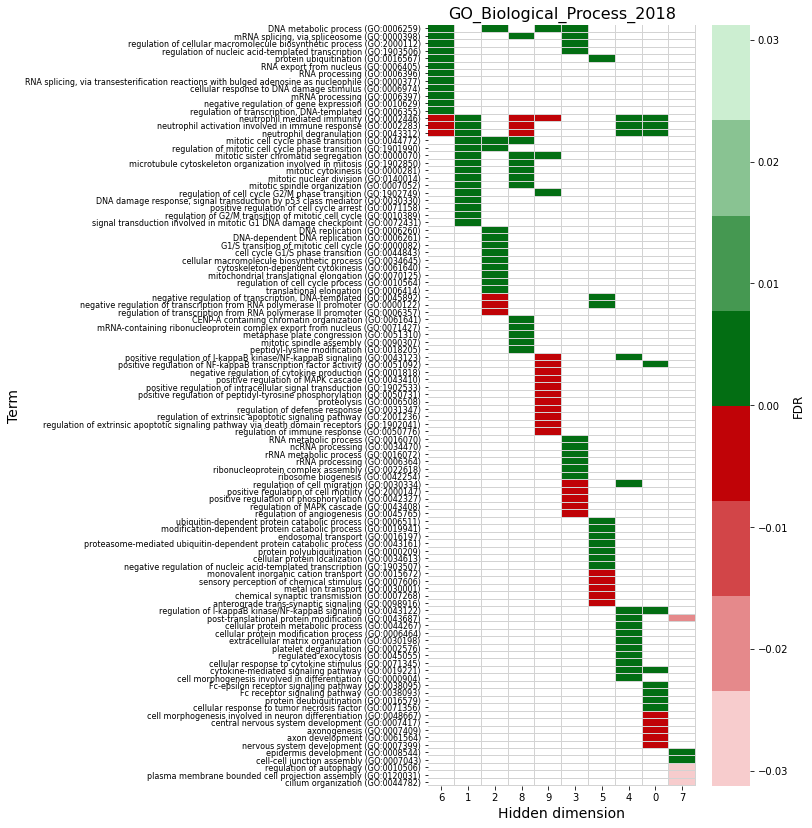

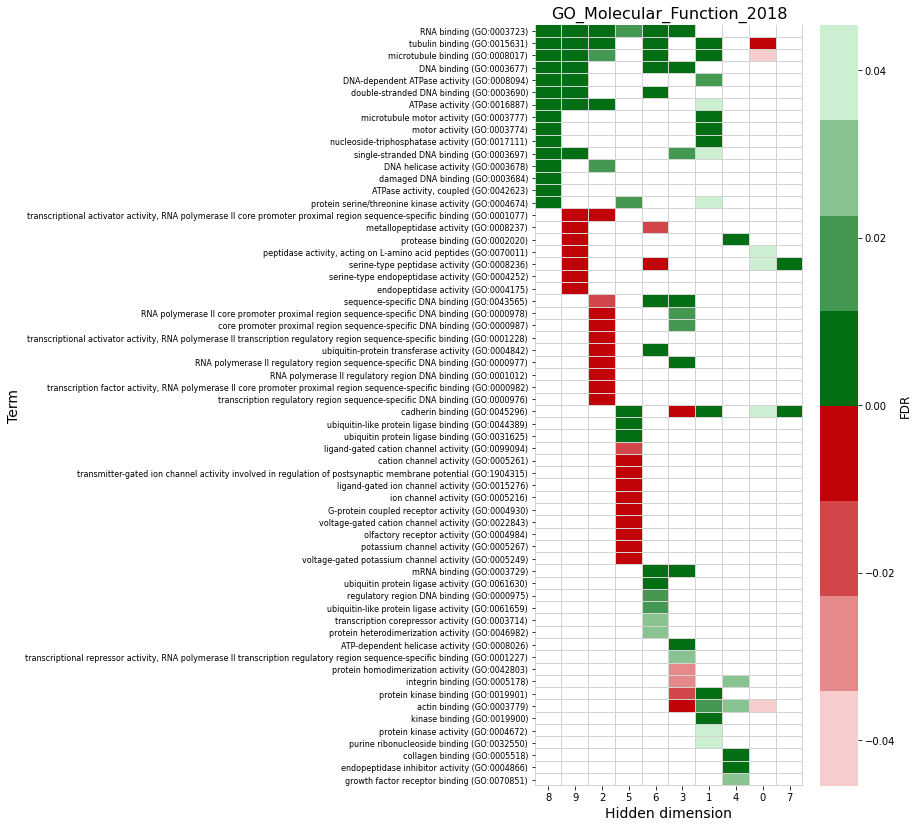

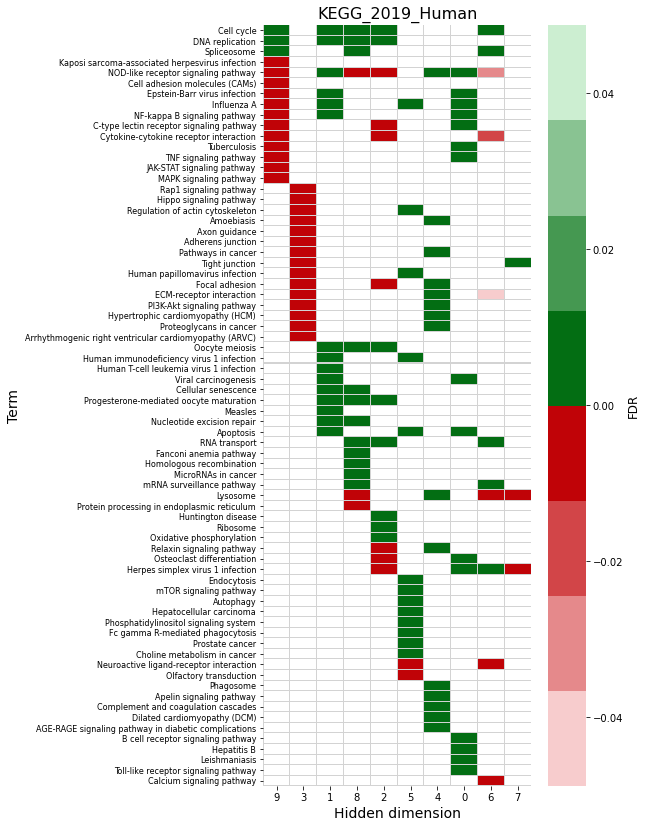

In [10]:
# Visualize the enrichment heatmap in every dimension
def signed_fdr_maker(row, value="fdr"):
    if row[value] == 0:
        if row["es"] > 0:
            return 0.00000001
        elif row["es"] < 0:
            return -0.00000001
        else:
            return 0
    else:
        if row["es"] != 0:
            return np.sign(row["es"]) * row[value]
        else:
            return row[value]
        
def sort_pivoted_dataframe(df):
    """Organize the enrichments in a ivoted DataFrame considering the importance of the dimensions"""
    # Get the order of the columns
    dim_counts_mat = np.zeros((df.shape[1], 2))
    for dim in list(df):
        # Calculate how many enriched columns are there
        dim_counts_mat[dim, 0] = df[dim].notnull().sum()
        # Calculate the sum of absolute fdr values
        dim_counts_mat[dim, 1] = np.abs(df[dim]).sum()
    dim_counts_df = pd.DataFrame(dim_counts_mat, columns=["Count", "FDR sum"])
    # Sort first by count of significant term, then by sum of fdr
    dim_order = list(dim_counts_df.sort_values(["Count", "FDR sum"], ascending=[False, True]).index)
    # Reorganize the columns of a DataFrame
    df = df[dim_order]
    # Iterate over dimensions and sort values w.r.t every dimension
    for dim in dim_order[::-1]:
        df["Inversed value"] = 1. / df[dim]
        df = df.sort_values("Inversed value", ascending=False)
    return df[dim_order]
        
sign_threshold = 0.05
value = "fdr"
top_k_terms = 15
for gene_set in results_dict:
    print(gene_set)
    enrich_df_combined = results_dict[gene_set][0]
    enrich_df_combined["signed " + value] = enrich_df_combined.apply(signed_fdr_maker, axis=1)
    enrich_df_filtered = enrich_df_combined[enrich_df_combined[value] < sign_threshold] 
    if top_k_terms:
        enrich_df_topk_combined = enrich_df_filtered.iloc[:0]
        for dim in range(10):
            df = enrich_df_filtered[enrich_df_filtered["Dim"] == dim]
            df_top = df.sort_values(value).iloc[:top_k_terms]
            enrich_df_topk_combined = pd.concat((enrich_df_topk_combined, df_top))
    if top_k_terms:
        enrich_df_pivoted = enrich_df_topk_combined.reset_index().pivot_table(values="signed " + value, index="Dim", columns="Term")
    else:
        enrich_df_pivoted = enrich_df_filtered.reset_index().pivot_table(values="signed " + value, index="Dim", columns="Term")
    print(enrich_df_topk_combined.shape, enrich_df_topk_combined.index.to_series().nunique(), enrich_df_pivoted.shape)
    print()
    plt.figure(figsize=(6, 14))
    plt.yticks(fontsize=8)
    plt.title(gene_set, fontsize=16)
    cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
    cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
    # Establish max absolute value for color mapping
    if enrich_df_pivoted.max().max() > np.abs(enrich_df_pivoted.min().min()):
        vmax = enrich_df_pivoted.max().max()
    else:
        vmax = np.abs(enrich_df_pivoted.min().min()) 
    df = sort_pivoted_dataframe(enrich_df_pivoted.transpose())
    ax = sns.heatmap(df, yticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                    cbar_kws={"label": "FDR"}, center=0.0, vmax=vmax, vmin=-vmax)
    ax.figure.axes[-1].yaxis.label.set_size(12)
    plt.ylabel("Term", fontsize=14)
    plt.xlabel("Hidden dimension", fontsize=14)
    ax.get_figure().savefig(
        os.path.join(
        filepath, "{} enrichment heatmap, {} terms from every dimension, {} {} threshold.pdf".format(gene_set, top_k_terms, sign_threshold, value)), bbox_inches='tight')
plt.show()

#### Get GO Terms list in a given dimension

In [15]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/"

'Dim 0'
'Dim 1'
'Dim 2'
'Dim 3'
'Dim 4'
'Dim 5'
'Dim 6'
'Dim 7'
'Dim 8'
'Dim 9'
 GO_Biological_Process_2018.pdf
 GO_Molecular_Function_2018.pdf
 gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl
 KEGG_2019_Human.pdf


In [3]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/Dim 0/"

GO_Biological_Process_2018  GO_Molecular_Function_2018	KEGG_2019_Human


In [5]:
def term_name_mapper(t):
    return t.split("(")[1][:-1]

filepath = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/"
with open(os.path.join(filepath, "gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl"), "rb") as f:
    results_dict = dill.load(f)
print(len(results_dict))
# Establish which metric you care about when determining significant terms
metric = "fdr"
# Establish significance threshold for the metric
threshold = 0.05
top_k_terms = 15
go_libraries = ["GO_Molecular_Function_2018", "GO_Biological_Process_2018"]
for gene_set in go_libraries:
    enrich_df_combined = results_dict[gene_set][0]
    for dim in range(10):
        # Extract terms for a given dimension
        df = enrich_df_combined[enrich_df_combined["Dim"] == dim]
        # Filter the terms with insignificant values
        df = df[df[metric] < threshold]
        if top_k_terms:
            df = df.sort_values(metric).iloc[:top_k_terms]
        # Save just the list of significant terms
        directory = os.path.join(filepath, "Dim " + str(dim), gene_set)
        df.index.map(term_name_mapper).to_series().to_csv(
            os.path.join(directory, "enriched_GO_terms_alone_top_{}_terms_{}_{}_thresh.txt".format(top_k_terms, threshold, metric),
                        ), index=False)
        # Save terms with pval
        df["GO ID"] = df.index.map(term_name_mapper)
        df[["GO ID", "pval"]].to_csv(
            os.path.join(directory, 
                "enriched_GO_terms_with_top_{}_terms_{}_{}_thresh.txt".format(top_k_terms, threshold, metric)), sep="\t", index=False)
        # Save terms with fdr
        df[["GO ID", "fdr"]].to_csv(
            os.path.join(directory, 
                         "enriched_GO_terms_with_fdr_top_{}_terms_{}_{}_thresh.txt".format(top_k_terms, threshold, metric)), sep="\t", index=False)

3


/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [47]:
os.path.join(directory, "enriched_GO_terms_alone.txt")

'../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/Dim 9/enriched_GO_terms_alone.txt'

## Gene enrichment analysis of latent dimesnions

#### Load computed tables and preprocess and check

In [8]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"

'GSEA files'
 network_all_cl_feats_scaled_state_dict.pth
 network_state_dict.pth
 network_without_augmentation_state_dict.pth
 network_without_independence_loss_state_dict.pth
 retrained_model_all_cl_feats_scaled.pkl
 retrained_model.pkl
 retrained_without_augmentation.pkl
 retrained_without_independence_loss.pkl
 specifications.json


In [33]:
models_directory = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"
table_name = "cell_lines_decoder_spearman_features_code_space_correlations.csv"
# Load the table 
df = pd.read_csv(os.path.join(models_directory, "GSEA files", table_name), index_col=0)
print(df.shape)

(241, 10)


In [34]:
df.head()

,0,1,2,3,4,5,6,7,8,9
PRKX_exp,0.025094,0.058651,0.023422,0.376876,-0.409279,-0.150282,0.247405,0.134040,0.225134,0.108441
TIE1_exp,-0.072529,0.066015,0.066565,0.380376,-0.086262,-0.237869,-0.294830,0.062571,-0.043802,-0.367139
BMPR2_exp,-0.257703,-0.361432,-0.047378,-0.365835,0.374886,-0.071634,0.104974,-0.352715,0.080433,0.230805
PKMYT1_exp,0.222472,0.504084,0.340721,0.276269,-0.316276,0.025324,-0.141649,0.074478,0.308697,0.179995
ABL2_exp,-0.359486,-0.120634,-0.097463,-0.161264,0.571138,0.173472,-0.079457,-0.273197,0.157549,-0.186219


In [35]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,0.006026,0.034972,0.012577,0.031991,-0.059362,0.007748,0.015733,0.019000,0.033648,-0.042244
std,0.227084,0.193234,0.179367,0.327469,0.281269,0.166726,0.167762,0.181434,0.193417,0.209939
min,-0.626120,-0.550397,-0.475230,-0.834313,-0.585092,-0.373317,-0.441805,-0.439788,-0.492983,-0.651785
25%,-0.143402,-0.089768,-0.093455,-0.169873,-0.274297,-0.118805,-0.091872,-0.096557,-0.084999,-0.203410
50%,0.023784,0.025657,0.004545,0.082917,-0.084111,0.001125,0.017210,0.030947,0.017974,-0.028918
75%,0.151383,0.169766,0.116404,0.297614,0.105772,0.121024,0.128417,0.134040,0.117064,0.114635
max,0.615320,0.516508,0.452158,0.647654,0.645118,0.464398,0.508472,0.514762,0.696664,0.444734


In [36]:
df.std()

0    0.227084
1    0.193234
2    0.179367
3    0.327469
4    0.281269
5    0.166726
6    0.167762
7    0.181434
8    0.193417
9    0.209939
dtype: float64

#### Preprocess for aprropriate GSEA method

In [31]:
# Pick dimension of interest
dimension = 0
data = ModelWithAutoencoders.preprocess_features_code_corr_table(df, dimension)
print(data.shape, data["Gene name"].nunique())
data.head(3)

(202, 3) 202


,Gene name,0,Abs. 0
FGFR1_exp,FGFR1,-0.626120,0.626120
MAPK7_exp,MAPK7,-0.625236,0.625236
MKNK1_exp,MKNK1,0.615320,0.615320


In [32]:
# Extract just gene names with correlations above certain threshold - DAVID type analysis
threshold = 0.4
topk_abs = None
topk_pos_and_neg = 10
# Extract genes above some threshold or top k genes
if topk_abs:
    ranked_list = list(data.iloc[:topk_abs]["Gene name"])
if topk_pos_and_neg:
    df = data.sort_values(str(dimension))
    ranked_list = list(df.iloc[:topk_pos_and_neg]["Gene name"]) + list(df.iloc[-topk_pos_and_neg:]["Gene name"])
else:
    ranked_list = list(data[data["Abs. " + str(dimension)] > threshold]["Gene name"])
print(len(ranked_list))
print("Minimal correlation:", data[data["Gene name"].isin(ranked_list)]["Abs. " + str(dimension)].min())
data[data["Gene name"].isin(ranked_list)]

20
Minimal correlation: 0.4197164817870548


,Gene name,0,Abs. 0
FGFR1_exp,FGFR1,-0.626120,0.626120
MAPK7_exp,MAPK7,-0.625236,0.625236
MKNK1_exp,MKNK1,0.615320,0.615320
CDK16_exp,CDK16,-0.537590,0.537590
CSNK1E_exp,CSNK1E,-0.532605,0.532605
PAK3_exp,PAK3,-0.528402,0.528402
BRSK1_exp,BRSK1,-0.517731,0.517731
DAPK3_exp,DAPK3,-0.497639,0.497639
DCLK1_exp,DCLK1,-0.497162,0.497162
PRKCD_exp,PRKCD,0.493987,0.493987


In [16]:
# Save the list in the appropriate format - txt, every gene in a newline
filename = "cell_lines_relevant_genes_in_dimension_{}_top_{}_neg_and_pos.txt".format(dimension, topk_pos_and_neg)
with open(os.path.join(models_directory, "GSEA files", filename), 'w') as f:
    for item in ranked_list:
        f.write("%s\n" % item)

#### Create lists of relvenat genes in all dimensions

In [37]:
threshold = 0.4
topk_abs = None
topk_pos_and_neg = 10
for dimension in range(10):
    data = ModelWithAutoencoders.preprocess_features_code_corr_table(df, dimension)
    # Extract genes above some threshold or top k genes
    if topk_abs:
        ranked_list = list(data.iloc[:topk_abs]["Gene name"])
    if topk_pos_and_neg:
        sorted_df = data.sort_values(str(dimension))
        ranked_list = list(sorted_df.iloc[:topk_pos_and_neg]["Gene name"]) + list(sorted_df.iloc[-topk_pos_and_neg:]["Gene name"])
    else:
        ranked_list = list(data[data["Abs. " + str(dimension)] > threshold]["Gene name"])
    print(dimension, len(ranked_list))
    print("Minimal correlation:", data[data["Gene name"].isin(ranked_list)]["Abs. " + str(dimension)].min())
    # Save the list in the appropriate format - txt, every gene in a newline
    filename = "cell_lines_relevant_genes_in_dimension_{}_top_{}_neg_and_pos.txt".format(dimension, topk_pos_and_neg)
    with open(os.path.join(models_directory, "GSEA files", filename), 'w') as f:
        for item in ranked_list:
            f.write("%s\n" % item)
    print()

0 20
Minimal correlation: 0.4197164817870548

1 20
Minimal correlation: 0.313560641136119

2 20
Minimal correlation: 0.32739835078959745

3 20
Minimal correlation: 0.5218341509758357

4 20
Minimal correlation: 0.4705745499706379

5 20
Minimal correlation: 0.2809544336876453

6 20
Minimal correlation: 0.2715284101274551

7 20
Minimal correlation: 0.3211562500916237

8 20
Minimal correlation: 0.27099482435890154

9 20
Minimal correlation: 0.30623054663925986



#### Analyze gene set enrichment analysis output - DAVID

In [8]:
models_directory = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"

In [9]:
os.listdir(os.path.join(models_directory, "Gene set enrichment analysis", "Cell lines", "DAVID outputs", "Dim 0"))

['DAVID_KEGG_enriched_pathways.tsv']

In [12]:
def david_enrichment_heatmap(filepath, table_name, pivot=True):
    # Initialize DataFrame combining all dimensions
    enrichment_df_combined = pd.read_csv(os.path.join(filepath, "Dim 0", table_name), sep="\t")
    enrichment_df_combined["Dim"] = [0] * enrichment_df_combined.shape[0]
    for dim in range(1, 10):
        # Load the DataFrame with enrichment
        enrichment_df = pd.read_csv(os.path.join(filepath, "Dim " + str(dim), table_name), sep="\t")
        enrichment_df["Dim"] = [dim] * enrichment_df.shape[0]
        enrichment_df_combined = pd.concat([enrichment_df_combined, enrichment_df])
    if pivot:
        return enrichment_df_combined, enrichment_df_combined.pivot(values="PValue", index="Dim", columns="Term")
    else:
        return enrichment_df_combined

In [13]:
filepath = os.path.join(models_directory, "Gene set enrichment analysis", "Cell lines", "DAVID outputs")
enrichment_df_combined, enrichment_df_pivoted = david_enrichment_heatmap(filepath, "DAVID_KEGG_enriched_pathways.tsv")
print(enrichment_df_combined.shape, enrichment_df_pivoted.shape)

(166, 14) (10, 69)


In [14]:
enrichment_df_combined.head()

,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR,Dim
0,KEGG_PATHWAY,hsa04722:Neurotrophin signaling pathway,4,20.0,0.001303,"BRAF, PIK3CA, MAPK7, PRKCD",14,120,6879,16.378571,0.113052,0.113052,1.414515,0
1,KEGG_PATHWAY,hsa04062:Chemokine signaling pathway,4,20.0,0.004554,"BRAF, LYN, PIK3CA, PRKCD",14,186,6879,10.566820,0.342920,0.189395,4.864523,0
2,KEGG_PATHWAY,hsa04810:Regulation of actin cytoskeleton,4,20.0,0.006396,"FGFR1, BRAF, PAK3, PIK3CA",14,210,6879,9.359184,0.445830,0.178613,6.769487,0
3,KEGG_PATHWAY,hsa05211:Renal cell carcinoma,3,15.0,0.006606,"BRAF, PAK3, PIK3CA",14,66,6879,22.334416,0.456519,0.141390,6.984871,0
4,KEGG_PATHWAY,hsa05218:Melanoma,3,15.0,0.007612,"FGFR1, BRAF, PIK3CA",14,71,6879,20.761569,0.504911,0.131166,8.009237,0


In [68]:
enrichment_df_combined["Term"].nunique()

69

In [15]:
enrichment_df_pivoted.head()

Term,hsa04010:MAPK signaling pathway,hsa04012:ErbB signaling pathway,hsa04014:Ras signaling pathway,hsa04015:Rap1 signaling pathway,hsa04020:Calcium signaling pathway,hsa04022:cGMP-PKG signaling pathway,hsa04024:cAMP signaling pathway,hsa04060:Cytokine-cytokine receptor interaction,hsa04062:Chemokine signaling pathway,hsa04066:HIF-1 signaling pathway,...,hsa05213:Endometrial cancer,hsa05214:Glioma,hsa05215:Prostate cancer,hsa05218:Melanoma,hsa05219:Bladder cancer,hsa05220:Chronic myeloid leukemia,hsa05221:Acute myeloid leukemia,hsa05223:Non-small cell lung cancer,hsa05230:Central carbon metabolism in cancer,hsa05231:Choline metabolism in cancer
Dim,,,,,,,,,,,,,,,,,,,,,
0,0.010693,0.011266,0.066062,0.057995,NaN,NaN,NaN,NaN,0.004554,NaN,...,0.094013,NaN,0.011516,0.007612,0.074834,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.031737,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.059539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.099234,NaN,NaN,0.063688,0.005590,NaN,0.086051,NaN,NaN
3,NaN,NaN,0.057105,0.050056,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.004868,0.000220,0.003539,0.035517,NaN,NaN,NaN,NaN,NaN,NaN,...,0.073118,0.090629,NaN,0.098610,0.058065,0.099934,0.078538,0.078538,0.089293,NaN


In [17]:
enrichment_df_combined, enrichment_df_pivoted = ModelWithAutoencoders.compute_david_enrichment_heatmap(
    filepath, "DAVID_KEGG_enriched_pathways.tsv")
print(enrichment_df_combined.shape, enrichment_df_pivoted.shape)

(166, 14) (10, 69)


In [18]:
enrichment_df_pivoted.head()

Term,hsa04010:MAPK signaling pathway,hsa04012:ErbB signaling pathway,hsa04014:Ras signaling pathway,hsa04015:Rap1 signaling pathway,hsa04020:Calcium signaling pathway,hsa04022:cGMP-PKG signaling pathway,hsa04024:cAMP signaling pathway,hsa04060:Cytokine-cytokine receptor interaction,hsa04062:Chemokine signaling pathway,hsa04066:HIF-1 signaling pathway,...,hsa05213:Endometrial cancer,hsa05214:Glioma,hsa05215:Prostate cancer,hsa05218:Melanoma,hsa05219:Bladder cancer,hsa05220:Chronic myeloid leukemia,hsa05221:Acute myeloid leukemia,hsa05223:Non-small cell lung cancer,hsa05230:Central carbon metabolism in cancer,hsa05231:Choline metabolism in cancer
Dim,,,,,,,,,,,,,,,,,,,,,
0,0.010693,0.011266,0.066062,0.057995,NaN,NaN,NaN,NaN,0.004554,NaN,...,0.094013,NaN,0.011516,0.007612,0.074834,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.031737,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.059539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.099234,NaN,NaN,0.063688,0.005590,NaN,0.086051,NaN,NaN
3,NaN,NaN,0.057105,0.050056,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.004868,0.000220,0.003539,0.035517,NaN,NaN,NaN,NaN,NaN,NaN,...,0.073118,0.090629,NaN,0.098610,0.058065,0.099934,0.078538,0.078538,0.089293,NaN


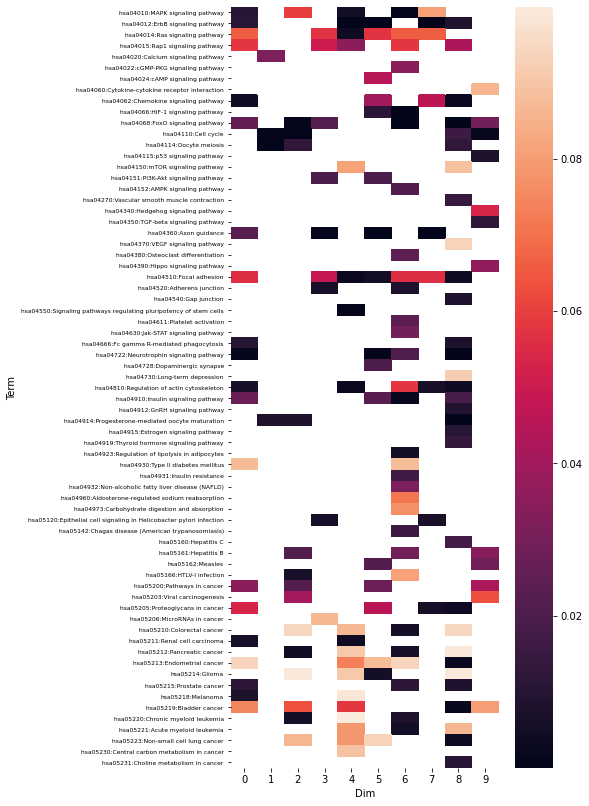

In [28]:
# Visualize enrichment heatmap
plt.figure(figsize=(6, 14))
sns.heatmap(enrichment_df_pivoted.transpose(), yticklabels=True)
plt.yticks(fontsize=6)

plt.show()

In [73]:
print(enrichment_df_pivoted.max().max(), enrichment_df_pivoted.min().min())

0.0999340478480246 1.4154183428881347e-06


#### Analyze gene set enrichment analysis output - GSEA

In [8]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/"

 cell_lines_decoder_spearman_features_code_space_correlations.csv
 cell_lines_relevant_genes_in_dimension_0_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_1_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_2_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_3_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_4_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_5_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_6_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_7_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_8_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_9_top_10_neg_and_pos.txt
 DAVID
'GSEA preranked'


In [9]:
import gseapy as gp
models_directory = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"

In [10]:
os.listdir(os.path.join(models_directory, "Gene set enrichment analysis", "Cell lines"))

['cell_lines_decoder_spearman_features_code_space_correlations.csv',
 'cell_lines_relevant_genes_in_dimension_0_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_1_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_2_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_3_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_4_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_5_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_6_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_7_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_8_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_9_top_10_neg_and_pos.txt',
 'DAVID',
 'GSEA preranked']

In [36]:
# Load DataFrame with code-reconstructed features correlations
corrs_df = pd.read_csv(os.path.join(models_directory, "Gene set enrichment analysis", "Cell lines", "cell_lines_decoder_spearman_features_code_space_correlations.csv"),
                      index_col=0)
print(corrs_df.shape)
corrs_df.head(3)

(241, 10)


,0,1,2,3,4,5,6,7,8,9
PRKX_exp,0.025094,0.058651,0.023422,0.376876,-0.409279,-0.150282,0.247405,0.134040,0.225134,0.108441
TIE1_exp,-0.072529,0.066015,0.066565,0.380376,-0.086262,-0.237869,-0.294830,0.062571,-0.043802,-0.367139
BMPR2_exp,-0.257703,-0.361432,-0.047378,-0.365835,0.374886,-0.071634,0.104974,-0.352715,0.080433,0.230805


In [38]:
def gseapy_preranked_enrichment_analysis_single_dim(corrs_df, dimension, gene_sets, permutation_num=1000, format="pdf", 
                                                    outdir="GSEA_Prerank", seed=11):
    """Perform GSEA Preranked analysis using GSEAPY."""
    data = ModelWithAutoencoders.preprocess_features_code_corr_table(corrs_df, dimension)
    rnk = data[["Gene name", str(dimension)]].reset_index(drop=True)
    prerank_results = gp.prerank(rnk=rnk, gene_sets=gene_sets, permutation_num=permutation_num, 
                                 format=format, seed=seed, outdir=outdir)
    return prerank_results

In [39]:
def gseapy_preranked_analysis_all_dims(corrs_df, gene_sets, value="pval", threshold=0.05,
                                       permutation_num=1000, format="pdf", outdir="GSEA_Prerank", seed=11, pivot=False,
                                       specified_save=False):
    """Perform GSEA Preranked analysis using GSEAPY for every hidden dimension and return heatmap
    with terms enriched in a given dimension."""
    # Perform the analysis for the first dimension
    # Establish directory in which results should be saved
    if specified_save:
        directory = os.path.join(outdir, "Dim 0", gene_sets)
    else:
        directory = outdir
    prerank_results = gseapy_preranked_enrichment_analysis_single_dim(corrs_df, 0, gene_sets,
                                                                     permutation_num=permutation_num, format=format,
                                                                     outdir=directory,
                                                                     seed=seed)
    enrichment_df_combined = prerank_results.res2d
    enrichment_df_combined["Dim"] = [0] * enrichment_df_combined.shape[0]
    for dimension in range(1, 10):
        # Establish directory in which results should be saved
        if specified_save:
            directory = os.path.join(outdir, "Dim " + str(dimension), gene_sets)
        else:
            directory = outdir
        prerank_results = gseapy_preranked_enrichment_analysis_single_dim(corrs_df, dimension, gene_sets,
                                                                         permutation_num=permutation_num, format=format,
                                                                         outdir=directory,
                                                                         seed=seed)
        df = prerank_results.res2d
        df["Dim"] = [dimension] * df.shape[0]
        enrichment_df_combined = pd.concat([enrichment_df_combined, df])
    if pivot:
        return enrichment_df_combined, enrichment_df_combined.reset_index().pivot(values="pval", index="Dim", columns="Term")
    return enrichment_df_combined

#### Run the Prerank analysis on multiple dimensions and  gene sets - cell lines

In [143]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/GSEA preranked/"

'Dim 0'  'Dim 2'  'Dim 4'  'Dim 6'  'Dim 8'
'Dim 1'  'Dim 3'  'Dim 5'  'Dim 7'  'Dim 9'


In [159]:
outdir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/GSEA preranked/"
print(outdir)

../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/GSEA preranked/


In [160]:
# Establish params and initialize a dictionary containing results for every gene set
gene_sets = ["GO_Biological_Process_2018", "GO_Molecular_Function_2018", "KEGG_2019_Human",
             "Reactome_2016"]
permutation_num = 1000
seed = 11
results_dict = {}
specified_save = True
for gene_set in gene_sets:
    enrichment_df_combined, enrichment_df_pivoted = gseapy_preranked_analysis_all_dims(corrs_df, gene_set, pivot=True,
                                                                                  permutation_num=permutation_num, seed=seed,
                                                                                  specified_save=specified_save,
                                                                                  outdir=outdir)
    results_dict[gene_set] = (enrichment_df_combined, enrichment_df_pivoted)
    # Save the results dict
    with open(os.path.join(outdir, "gsea_preranked_enrichment_results_in_different_gene_sets_results_dict.pkl"), "wb") as f:
        dill.dump(results_dict, f)
    print(gene_set, len(results_dict))
print("Done")

GO_Biological_Process_2018 1
GO_Molecular_Function_2018 2
KEGG_2019_Human 3
Reactome_2016 4
Done


In [41]:
# Load the dictionary with the enrichment results
outdir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/GSEA preranked/"
print(outdir)
with open(os.path.join(outdir, "gsea_preranked_enrichment_results_in_different_gene_sets_results_dict.pkl"), "rb") as f:
    results_dict = dill.load(f)
print(len(results_dict))

4


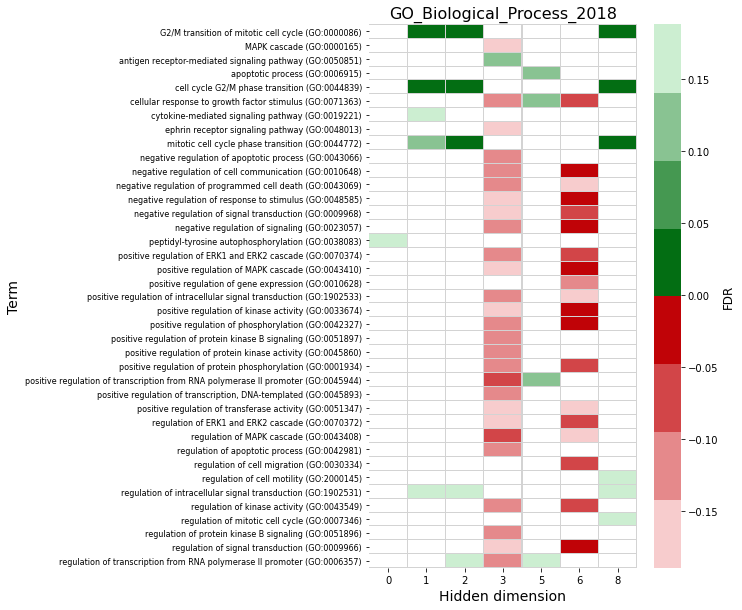

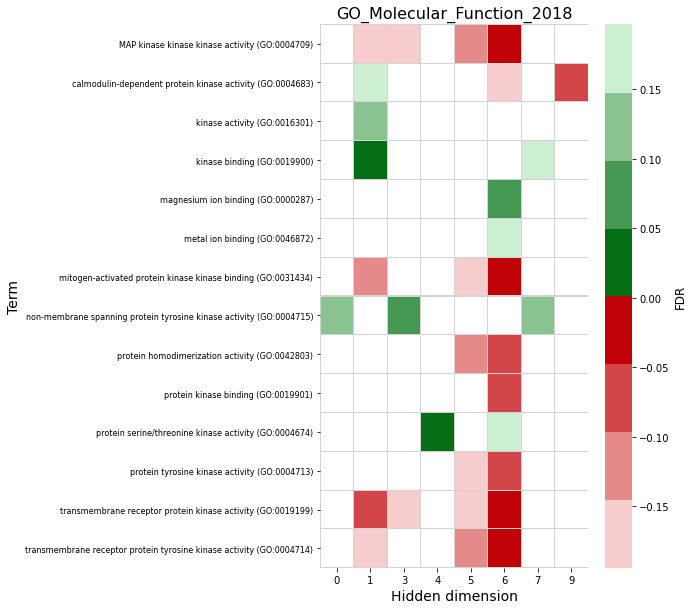

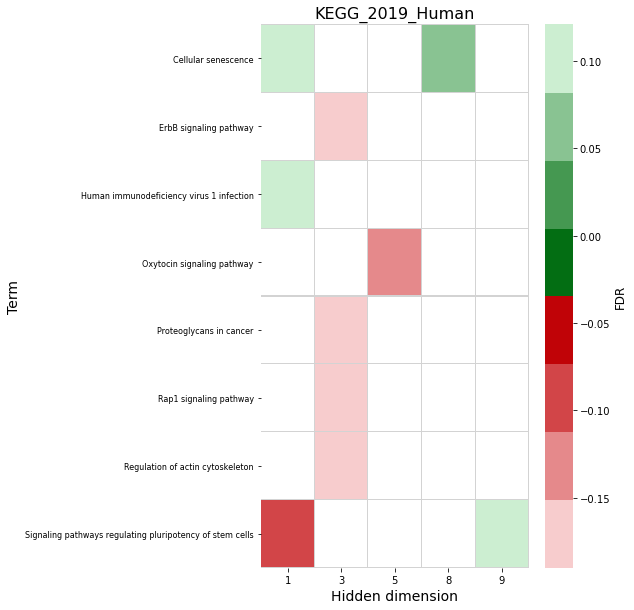

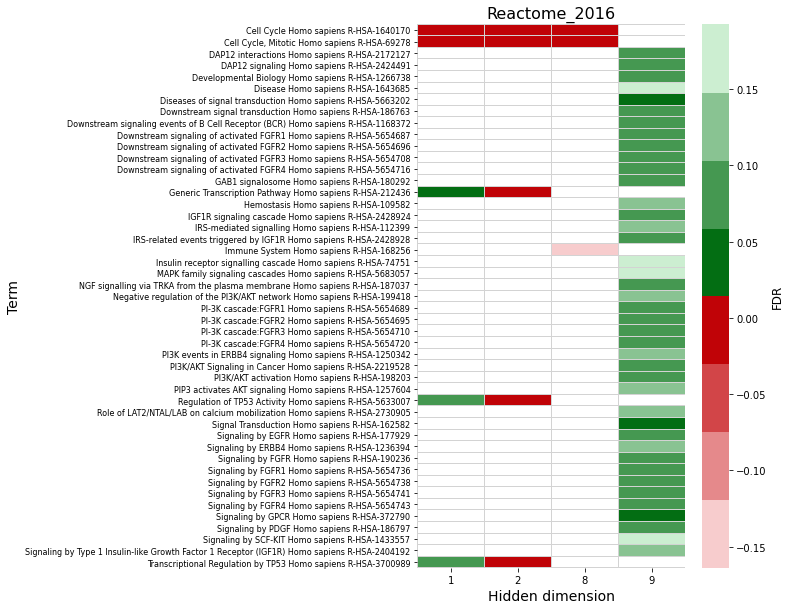

In [244]:
# Visualize the enrichment heatmap in every dimension
sign_threshold = 0.2
value = "fdr"
for gene_set in results_dict:
    enrich_df_combined = results_dict[gene_set][0]
    enrich_df_combined["signed " + value] = enrich_df_combined[value] * (enrich_df_combined["es"] / abs(enrich_df_combined["es"]))
    enrich_df_filtered = enrich_df_combined[enrich_df_combined[value] < sign_threshold] 
    enrich_df_pivoted = enrich_df_filtered.reset_index().pivot_table(values="signed " + value, index="Dim", columns="Term")
    plt.figure(figsize=(6, 10))
    plt.yticks(fontsize=8)
    plt.title(gene_set, fontsize=16)
    cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
    cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
    ax = sns.heatmap(enrich_df_pivoted.transpose(), yticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                    cbar_kws={"label": "FDR"})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    plt.ylabel("Term", fontsize=14)
    plt.xlabel("Hidden dimension", fontsize=14)
    ax.get_figure().savefig(gene_set + ".pdf", bbox_inches='tight')
plt.show()

#### Run the Prerank analysis on multiple dimensions and  gene sets - drugs

In [305]:
import gseapy as gp

In [306]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Drugs/"

 drugs_decoder_spearman_features_code_space_correlations.csv  'GSEA Prerank'


In [307]:
# Load drug correlations DataFrame
models_directory = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay"
corrs_df = pd.read_csv(
os.path.join(models_directory, "Gene set enrichment analysis/Drugs/", "drugs_decoder_spearman_features_code_space_correlations.csv"),
index_col=0)
print(corrs_df.shape)
corrs_df.head(2)

(294, 10)


,0,1,2,3,4,5,6,7,8,9
Protein,,,,,,,,,,
MAPKAPK2,-0.049508,-0.289004,0.043554,-0.188893,0.044472,-0.211196,0.080370,0.136261,-0.041807,0.098141
MARK1,0.007419,0.096720,0.070300,-0.040474,-0.247864,-0.384909,0.142332,-0.254469,-0.175831,-0.178941


In [308]:
outdir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Drugs/GSEA Prerank/"
print(outdir)

../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Drugs/GSEA Prerank/


In [21]:
# Establish params and initialize a dictionary containing results for every gene set
gene_sets = ["GO_Biological_Process_2018", "GO_Molecular_Function_2018", "KEGG_2019_Human",
             "Reactome_2016"]
permutation_num = 1000
seed = 11
results_dict = {}
specified_save = True
for gene_set in gene_sets:
    enrichment_df_combined, enrichment_df_pivoted = gseapy_preranked_analysis_all_dims(corrs_df, gene_set, pivot=True,
                                                                                  permutation_num=permutation_num, seed=seed,
                                                                                  specified_save=specified_save,
                                                                                  outdir=outdir)
    results_dict[gene_set] = (enrichment_df_combined, enrichment_df_pivoted)
    # Save the results dict
    with open(os.path.join(outdir, "gsea_preranked_enrichment_results_in_different_gene_sets_results_dict.pkl"), "wb") as f:
        dill.dump(results_dict, f)
    print(gene_set, len(results_dict))
print("Done")

GO_Biological_Process_2018 1
GO_Molecular_Function_2018 2
KEGG_2019_Human 3
Reactome_2016 4
Done


In [310]:
# Load the dictionary with the enrichment results
outdir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Drugs/GSEA Prerank/"
print(outdir)
with open(os.path.join(outdir, "gsea_preranked_enrichment_results_in_different_gene_sets_results_dict.pkl"), "rb") as f:
    results_dict = dill.load(f)
print(len(results_dict))

../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Drugs/GSEA Prerank/
4


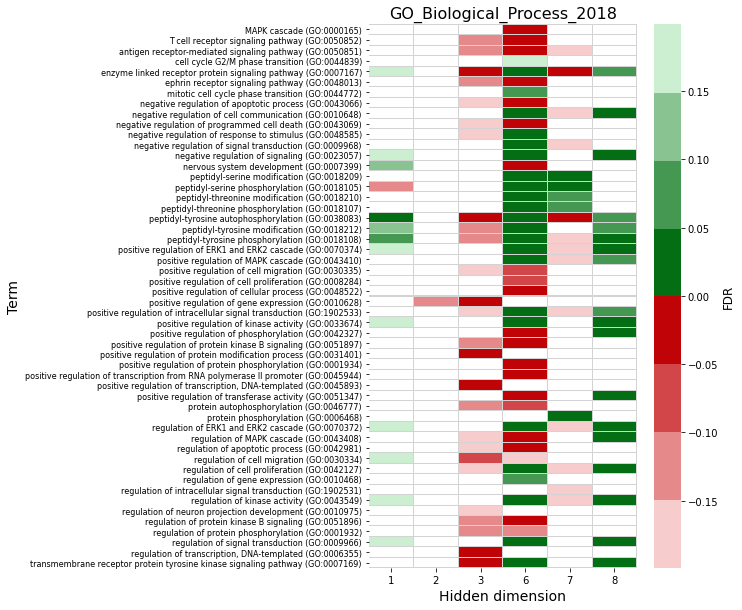

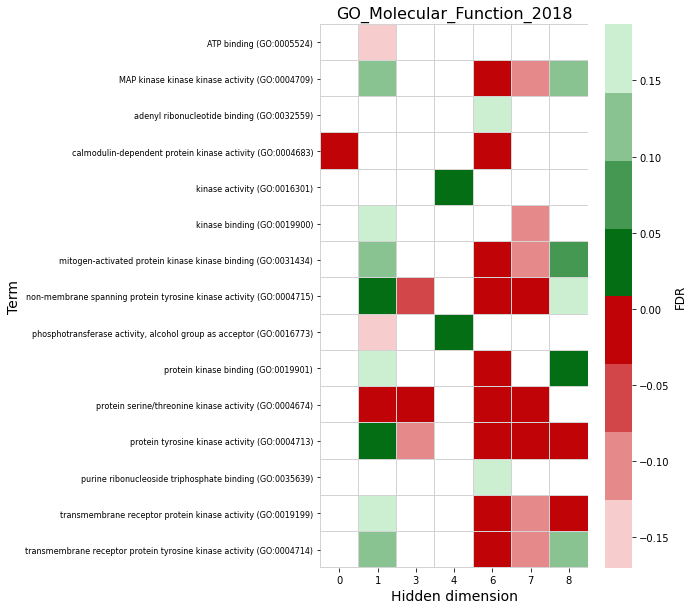

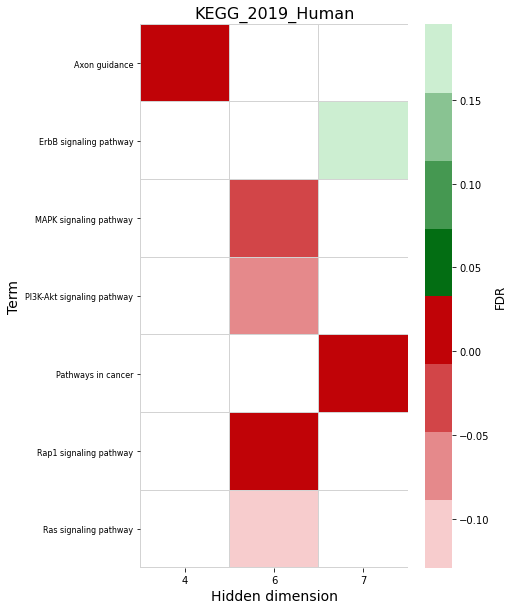

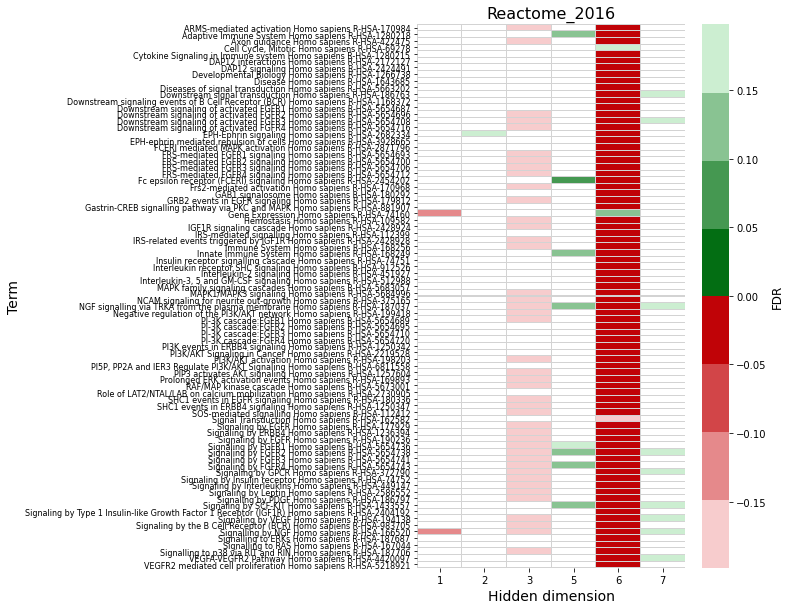

In [311]:
# Visualize the enrichment heatmap in every dimension
sign_threshold = 0.2
value = "fdr"
for gene_set in results_dict:
    enrich_df_combined = results_dict[gene_set][0]
    enrich_df_combined["signed " + value] = enrich_df_combined[value] * (enrich_df_combined["es"] / abs(enrich_df_combined["es"]))
    enrich_df_filtered = enrich_df_combined[enrich_df_combined[value] < sign_threshold] 
    enrich_df_pivoted = enrich_df_filtered.reset_index().pivot_table(values="signed " + value, index="Dim", columns="Term")
    plt.figure(figsize=(6, 10))
    plt.yticks(fontsize=8)
    plt.title(gene_set, fontsize=16)
    cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
    cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
    ax = sns.heatmap(enrich_df_pivoted.transpose(), yticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                    cbar_kws={"label": "FDR"})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    plt.ylabel("Term", fontsize=14)
    plt.xlabel("Hidden dimension", fontsize=14)
    ax.get_figure().savefig(gene_set + ".pdf", bbox_inches='tight')
plt.show()

## Create tables with top relevant genes in every dimension

In [53]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Drugs/"

 drugs_decoder_spearman_features_code_space_correlations.csv  'GSEA Prerank'


In [284]:
# Load the pre-computed correlation tables
model_directory = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"
corr_df_cell_lines = pd.read_csv(os.path.join(model_directory, "Gene set enrichment analysis", "Cell lines",
                            "cell_lines_decoder_spearman_features_code_space_correlations.csv"), index_col=0)
corr_df_drugs = pd.read_csv(os.path.join(model_directory, "Gene set enrichment analysis", "Drugs", 
                                "drugs_decoder_spearman_features_code_space_correlations.csv"), index_col=0)
print(corr_df_cell_lines.shape, corr_df_drugs.shape)

(241, 10) (294, 10)


In [245]:
corr_df_cell_lines.head()

,0,1,2,3,4,5,6,7,8,9
PRKX_exp,0.025094,0.058651,0.023422,0.376876,-0.409279,-0.150282,0.247405,0.134040,0.225134,0.108441
TIE1_exp,-0.072529,0.066015,0.066565,0.380376,-0.086262,-0.237869,-0.294830,0.062571,-0.043802,-0.367139
BMPR2_exp,-0.257703,-0.361432,-0.047378,-0.365835,0.374886,-0.071634,0.104974,-0.352715,0.080433,0.230805
PKMYT1_exp,0.222472,0.504084,0.340721,0.276269,-0.316276,0.025324,-0.141649,0.074478,0.308697,0.179995
ABL2_exp,-0.359486,-0.120634,-0.097463,-0.161264,0.571138,0.173472,-0.079457,-0.273197,0.157549,-0.186219


In [289]:
k = 10   # How many positive and negative genes to extract
corr_thresh = 0.2
relevant_genes_dict = {"Cell lines": {},
                      "Drugs": {}}
for dim in range(10):
    # Preprocess raw feature correlation DataFrame
    genes_df_cell_lines = ModelWithAutoencoders.preprocess_features_code_corr_table(corr_df_cell_lines, dim)
    genes_df_drugs = ModelWithAutoencoders.preprocess_features_code_corr_table(corr_df_drugs, dim)
    top_k_pos_cl = genes_df_cell_lines.sort_values(str(dim)).iloc[-k:].sort_values(str(dim), ascending=False)
    top_k_pos_cl = top_k_pos_cl[top_k_pos_cl["Abs. " + str(dim)] > 0.2]
    top_k_neg_cl = genes_df_cell_lines.sort_values(str(dim)).iloc[:k]
    top_k_neg_cl = top_k_neg_cl[top_k_neg_cl["Abs. " + str(dim)] > 0.2]
    
    top_k_pos_drugs = genes_df_drugs.sort_values(str(dim)).iloc[-k:].sort_values(str(dim), ascending=False)
    top_k_pos_drugs = top_k_pos_drugs[top_k_pos_drugs["Abs. " + str(dim)] > 0.2]
    top_k_neg_drugs = genes_df_drugs.sort_values(str(dim)).iloc[:k]
    top_k_neg_drugs = top_k_neg_drugs[top_k_neg_drugs["Abs. " + str(dim)] > 0.2]
    
    # Create lists with just teh genes - cell lines
    top_list_pos_cl = list(top_k_pos_cl["Gene name"])
    if len(top_list_pos_cl) < k:
        top_list_pos_cl = top_list_pos_cl + [np.nan] * (k - len(top_list_pos_cl))
    top_list_neg_cl = list(top_k_neg_cl["Gene name"])
    if len(top_list_neg_cl) < k:
        top_list_neg_cl = top_list_neg_cl + [np.nan] * (k - len(top_list_neg_cl))
    # Create lists with just teh genes - drugs
    top_list_pos_drugs = list(top_k_pos_drugs["Gene name"])
    if len(top_list_pos_drugs) < k:
        top_list_pos_drugs = top_list_pos_drugs + [np.nan] * (k - len(top_list_pos_drugs))
    top_list_neg_drugs = list(top_k_neg_drugs["Gene name"])
    if len(top_list_neg_drugs) < k:
        top_list_neg_drugs = top_list_neg_drugs + [np.nan] * (k - len(top_list_neg_drugs))
        
    print(len(top_list_pos_cl), len(top_list_neg_cl), len(top_list_pos_drugs), len(top_list_neg_drugs))
    relevant_genes_dict["Cell lines"][dim] = top_list_pos_cl + top_list_neg_cl
    relevant_genes_dict["Drugs"][dim] = top_list_pos_drugs + top_list_neg_drugs

10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10
10 10 10 10


In [295]:
top_genes_df_cell_lines_df = pd.DataFrame(relevant_genes_dict["Cell lines"])
top_genes_df_drugs_df = pd.DataFrame(relevant_genes_dict["Drugs"])
print(top_genes_df_cell_lines_df.shape, top_genes_df_drugs_df.shape)

(20, 10) (20, 10)


In [301]:
# Save the tables
top_genes_df_cell_lines_df.to_csv("top_genes_df_cell_lines_df.csv", index=False)
top_genes_df_drugs_df.to_csv("top_genes_df_drugs_df.csv", index=False)

In [296]:
top_genes_df_cell_lines_df

,0,1,2,3,4,5,6,7,8,9
0,MKNK1,AURKB,MERTK,CSK,AXL,TESK1,STK33,PAK1,MELK,MARK1
1,PRKCD,PKMYT1,CHEK1,FYN,FER,ABL2,TLK1,SRC,TTK,ACVR2A
2,CLK4,WEE1,PLK1,RIOK1,MAP4K4,EPHB4,WEE1,CDK8,NEK2,CDK4
3,LYN,AURKA,CDK4,ATM,ACVR1,GSK3B,NLK,PAK6,CDK1,BMPR1A
4,RIOK3,PHKG2,AURKA,ADCK3,ABL2,GAK,SIK2,FRK,AURKB,TGFBR1
5,EPHA1,MARK2,CIT,FES,NEK7,LIMK1,PIM1,ACVRL1,PLK4,CDK2
6,SLK,PLK1,EPHA4,BRSK1,MYLK,TNK2,CLK1,SRPK1,PLK1,CDK1
7,TLK1,CDK1,FGFR4,BLK,AKT3,STK16,CAMK1D,LYN,AURKA,NEK2
8,BRAF,LIMK1,PKMYT1,CLK2,NEK6,AKT1,INSR,NTRK2,RAF1,EPHA3
9,PIK3CA,CAMK2G,DAPK1,TLK2,LATS2,MKNK2,PIK3CA,TNK1,PIP5K1A,FYN


In [300]:
top_genes_df_drugs_df

,0,1,2,3,4,5,6,7,8,9
0,MK14,CSK,CDK2,GSK3A,AKT1,AKT3,CLK2,MLCK,FAK1,CSNK1D
1,RIOK3,YES,MST3,CDK16,PIK3CA(E545K),NaN,CLK4,CAMK2G,ALK,ADCK4
2,NaN,ALK,CAMK1G,PLK1,PIK3CA,NaN,CLK1,KCC2D,IGF1R,PKMYT1
3,NaN,EGFR(L861Q),TNNI3K,CDK9,AKT3,NaN,CAMK2A,PCTK3,FER,MK11
4,NaN,SLK,YSK1,CDK2,NaN,NaN,DYRK1B,PIM3,STK33,CSNK1E
5,NaN,EGFR(S752-I759del),PAK1,ERK8,NaN,NaN,AAK1,CAMK2B,PLK1,BMPR2
6,NaN,TIE2,YANK3,ERK5,NaN,NaN,CSNK1A1L,PAK2,INSRR,ADCK3
7,NaN,SRMS,EPHA3,PCTK2,NaN,NaN,MYLK,PIM1,LTK,AKT1
8,NaN,FER,LIMK1,CDK3,NaN,NaN,PIM1,CDK11,TNK2,ERK4
9,NaN,EGFR,EPHA8,PCTK3,NaN,NaN,KCC2D,AKT3,NaN,NEK5


In [303]:
gp.get_library_name()

list

In [304]:
with open('library_names.txt', 'w') as f:
    for item in gp.get_library_name():
        f.write("%s\n" % item)

## Model analysis widget - best model retrained on the whole data

In [164]:
! ls "../Final results/Models retrained on the whole data/"

'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 2'
'One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4'


In [ ]:
models_directories = "../Final results/Models retrained on the whole data/"

In [21]:
def model_analysis_widget(experiment, model, dependence_penalty, drug_name, topk_drugs, display_drug_meta, display_cell_lines_code_cov, 
                          display_drug_code_cov, display_drug_code_feats_atrr, display_cl_code_feats_atrr,
                          cl_axis1, cl_axis2, display_feature_importances, normalize_feat_imp, k_important_feats,
                          feature_type, display_response_vs_feat):
    # Establish directory where the trained model is stored
    model_dir = os.path.join(models_directories, experiment, model + ".pkl")
    # Get drug GDSC ID
    drug_id = full_dataset.gdsc_name_to_gdsc_id_mapper[drug_name]
    # Display best performing drugs if specified
    if topk_drugs > 0:
        per_drug_performance = pd.read_csv(os.path.join(model_dir, "per_drug_training_results.csv"))
        display(per_drug_performance.sort_values(
            "Model correlation", ascending=False).head(topk_drugs).style.set_caption("Top {} drugs".format(topk_drugs)))
    if display_drug_meta:
        display(full_dataset.drug_metadata[full_dataset.drug_metadata["Drug ID"] == drug_id][
            ["Drug ID", "Name", "Targets", "Target pathway", "PubCHEM"]].style.set_caption("Drug metadata"))
    # Load the model
    with open(model_dir, "rb") as f:
        model = dill.load(f)
    network = model.network
    network.eval()
    # Compute codes and reconstructions for drug an cell lines
    # Compute reconstructions for drugs
    drug_codes, drug_recs = network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
    # Create a DataFrame with drugs and their code embeddings
    drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
    # Compute reconstructions for all cell lines
    cl_codes, cl_recs = network.cell_line_autoencoder(torch.from_numpy(
        cell_line_data_df.values).float())
    # Create a DataFrame with cell lines and their code embeddings
    cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
    # Visualize cell line representations covariance matrix if specified
    if display_cell_lines_code_cov:
        # Compute covariance matrix for cell line embeddings
        cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
        sns.set(font_scale=1.1)
        plt.figure(figsize=(5, 4))
        plt.title("Cell lines codes covariance matrix")
        ax = sns.heatmap(np.abs(cl_codes_cov), annot=False)
        ax.tick_params(labelsize=10)

    # Visualize drug representations covariance matrix if specified
    if display_drug_code_cov:
        # Compute covariance matrix for cell line embeddings
        drug_codes_cov = np.cov(drug_codes.detach().numpy(), rowvar=False)
        sns.set(font_scale=1.1)
        plt.figure(figsize=(5, 4))
        plt.title("Drug codes covariance matrix")
        ax = sns.heatmap(np.abs(drug_codes_cov), annot=False)
        ax.tick_params(labelsize=10)
        
    # Display clustered heatmap of feature-code attributions - drugs
    if display_drug_code_feats_atrr:
        def net(drug_input):
            return network.drug_autoencoder(drug_input)[0]
        # For all drugs, heatmap if features vs. attributions
        drug_input = torch.from_numpy(drug_data_df.values).float()
        drug_input.requires_grad_()

        # Integrated Gradients
        ig = attr.IntegratedGradients(net)

        # Compute drug code attributions for every dimension in code space
        drug_code_attributions_df = pd.DataFrame()
        for dim in range(network.drug_autoencoder(drug_input[0])[0].shape[0]):
            code_attributions, delta = ig.attribute(drug_input, target=dim,  return_convergence_delta=True)
            code_attributions = np.abs(code_attributions.detach().numpy())
            code_attributions = np.mean(code_attributions, axis=0)
            drug_code_attributions_df[dim] = code_attributions
        drug_code_attributions_df.index = drug_data_df.columns
        # Normalize the data
        index = drug_code_attributions_df.index
        cols = drug_code_attributions_df.columns
        drug_code_attributions_df = normalize(drug_code_attributions_df)
        drug_code_attributions_df = pd.DataFrame(drug_code_attributions_df, index=index,
                                           columns=cols)
        # Hierarchical clustering of the scaled heatmap - assign to clusters
        num_clusters = 10
        cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
        assignments = cluster.fit_predict(drug_code_attributions_df)

        drug_code_attributions_df["cluster_assignment"] = assignments
        drug_code_attributions_df = drug_code_attributions_df.sort_values("cluster_assignment")
        # Create a dictionary mapping each cluster assignmnet to color
        color_dict = {}
        palette = sns.color_palette(n_colors=num_clusters)
        for cl, color in zip(drug_code_attributions_df.cluster_assignment.unique(), palette):
            color_dict[cl] = color
        prot_color_map = {}
        for prot, assign in zip(drug_code_attributions_df.index, drug_code_attributions_df.cluster_assignment):
            prot_color_map[prot] = color_dict[assign]
        # Plot clustermap using seaborn
        grid = sns.clustermap(drug_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                              col_cluster=False, 
                              row_colors=[prot_color_map[x] for x in drug_code_attributions_df.index], 
                              yticklabels="auto", mask=None, figsize=(5, 5))
        grid.fig.suptitle("Heatmap of drug features-code dimensions attribbutions", fontsize=12)
        plt.tight_layout()

    # Display clustered heatmap of feature-code attributions - cell lines
    if display_cl_code_feats_atrr:
        def net(cl_input):
            return network.cell_line_autoencoder(cl_input)[0]
        # For all drugs, heatmap if features vs. attributions
        cl_input = torch.from_numpy(cell_line_data_df.values).float()
        cl_input.requires_grad_()

        # Integrated Gradients
        ig = attr.IntegratedGradients(net)

        # Compute drug code attributions for every dimension in code space
        cl_code_attributions_df = pd.DataFrame()
        for dim in range(network.cell_line_autoencoder(cl_input[0])[0].shape[0]):
            code_attributions, delta = ig.attribute(cl_input, target=dim,  return_convergence_delta=True)
            code_attributions = np.abs(code_attributions.detach().numpy())
            code_attributions = np.mean(code_attributions, axis=0)
            cl_code_attributions_df[dim] = code_attributions

        cl_code_attributions_df.index = cell_line_data_df.columns
        # Normalize the data
        index = cl_code_attributions_df.index
        cols = cl_code_attributions_df.columns
        cl_code_attributions_df = normalize(cl_code_attributions_df)
        cl_code_attributions_df = pd.DataFrame(cl_code_attributions_df, index=index,
                                           columns=cols)
        # Hierarchical clustering of the scaled heatmap - assign to clusters
        num_clusters = 10
        cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
        assignments = cluster.fit_predict(cl_code_attributions_df)

        cl_code_attributions_df["cluster_assignment"] = assignments
        cl_code_attributions_df = cl_code_attributions_df.sort_values("cluster_assignment")
        # Create a dictionary mapping each cluster assignmnet to color
        color_dict = {}
        palette = sns.color_palette(n_colors=num_clusters)
        for cl, color in zip(cl_code_attributions_df.cluster_assignment.unique(), palette):
            color_dict[cl] = color
        prot_color_map = {}
        for prot, assign in zip(cl_code_attributions_df.index, cl_code_attributions_df.cluster_assignment):
            prot_color_map[prot] = color_dict[assign]
        # Plot clustermap using seaborn
        grid = sns.clustermap(cl_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                              col_cluster=False, 
                              row_colors=[prot_color_map[x] for x in cl_code_attributions_df.index], 
                              yticklabels="auto", mask=None, figsize=(5, 5))
        grid.fig.suptitle("Heatmap of cell line features-code dimensions attribbutions", fontsize=12)
        plt.tight_layout()  
        
    # Code visualizations for a given drug
    samples = samples_all[samples_all["DRUG_ID"] == drug_id]
    sampled_cell_lines_codes = cl_codes_df.loc[samples["COSMIC_ID"].values]
    sampled_cell_lines_codes["True " + str(global_response_metric)] = samples[global_response_metric].values

    # Visualize by two most variant code dimensions
    # Visualize in 2D
    if not (cl_axis1 is None and cl_axis2 is None):
        # Extract top 2 diagonal indexes
        cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
        top_2 = cl_codes_cov.diagonal().argsort()[-2:][::-1]
        if (cl_axis1 == "max") or (cl_axis2 == "max"):
            cl_axis1, cl_axis2 = top_2[0], top_2[1]
        if cl_axis1 is not None: 
            sns.set_style("dark")
            plt.figure(figsize=(5, 4))
            cmap = ListedColormap(sns.color_palette("YlOrRd"))
            plt.title("Cell lines in code space: " + drug_name)
            plt.scatter(sampled_cell_lines_codes[cl_axis1], sampled_cell_lines_codes[cl_axis2], 
                        c=sampled_cell_lines_codes["True " + str(global_response_metric)].values, s=20., 
                        cmap=cmap)
            plt.xlabel("Axis {}".format(cl_axis1))
            plt.ylabel("Axis {}".format(cl_axis2))
            #plt.legend()
            plt.grid(False)
            plt.colorbar()
        if cl_axis1 is None:
            plt.figure(figsize=(5, 4))
            plt.title("True response vs. latent dimension: " + drug_name)
            sns.regplot(sampled_cell_lines_codes[cl_axis2], 
                        sampled_cell_lines_codes["True " + str(global_response_metric)].values,
                        scatter_kws={"s":20})
    # Display feature sensitivities if specified
    if display_feature_importances:
        # Analyze whole rec system
        def net(drug_input, cl_input):
            return network(drug_input, cl_input)[0]
        
        ig = attr.IntegratedGradients(net)
        # Establish samples on which to compute importances
        samples  = samples_all[samples_all["DRUG_ID"] == drug_id]
        cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
        drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()
        cl_input.requires_grad_()
        drug_input.requires_grad_()
        attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
        drug_attributions, cl_attributions = attributions
        drug_attributions = drug_attributions.detach().numpy()
        cl_attributions = cl_attributions.detach().numpy()
        drug_attributions = np.mean(drug_attributions, axis=0)
        cl_attributions = np.mean(cl_attributions, axis=0)
        if normalize_feat_imp:
            drug_attributions = drug_attributions / np.abs(drug_attributions).sum()
            cl_attributions = cl_attributions / np.abs(cl_attributions).sum()
        drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
        cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

        all_features_attributions = drug_attributions + cl_attributions
        # Sort by importance
        drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
        cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

        # Plot k most important drug or cell line features
        if feature_type == "cell line":
            plt.figure()
            sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
            plt.title("{} feature importances: {}".format("Cell line", drug_name))
            plt.xticks(rotation=90, fontsize=8)
        elif feature_type == "both":
            plt.figure()
            plt.title("{} feature importances: {}".format("Cell line", drug_name))
            sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
            plt.xticks(rotation=90, fontsize=8)
            
            plt.figure()
            plt.title("{} feature importances: {}".format("Drug", drug_name))
            sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
            plt.xticks(rotation=90, fontsize=8)
        else:
            plt.figure()
            sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
            plt.title("{} feature importances: {}".format("Drug", drug_name))
            plt.xticks(rotation=90, fontsize=8)
            
        if display_response_vs_feat:
            response_predictions = net(drug_input, cl_input)
            true_response = samples[global_response_metric]
            def plot_response_vs_feat(feature, response):
                x = cell_line_data_original_df.loc[samples["COSMIC_ID"].values][feature]
                if response == "predicted":
                    y = response_predictions.detach().numpy().reshape(-1)
                else:
                    y = true_vals
#                 fig = go.Figure(data=go.Scatter(x=x, y=y, mode="markers",
#                                                 text=samples["COSMIC_ID"]))
#                 fig.show()
                plt.figure()
                sns.regplot(x, y)
                plt.title("Response vs {}".format(feature))
                plt.xlabel(feature)
                plt.ylabel(global_response_metric)
            interact(plot_response_vs_feat,
            feature=[x[0] for x in cl_attributions[:k_important_feats]],
            response=["predicted", "true"])
        
    plt.show()
    

model_analysis_widget_result = interactive(model_analysis_widget,
                experiment=os.listdir(models_directories),
                model=["retrained_model", "retrained_model_without_independence_penalty", "retrained_model_all_cl_feats_scaled"],
                dependence_penalty=[True, False],
                drug_name=[x for x in full_dataset.gdsc_name_to_gdsc_id_mapper.keys()],
                topk_drugs=widgets.IntSlider(value=0, min=0, max=74, step=1),
                display_drug_meta=[False, True],
                display_cell_lines_code_cov=[False, True], 
                display_drug_code_cov=[False, True],
                display_drug_code_feats_atrr=[False, True],
                display_cl_code_feats_atrr=[False, True],
                cl_axis1=[None] + ["max"] + [x for x in range(10)],
                cl_axis2=[None] + ["max"] + [x for x in range(10)],
                display_feature_importances=[False, True],
                normalize_feat_imp=[False, True],
                k_important_feats=widgets.IntSlider(value=10, min=1, max=30,step=1),
                feature_type=["cell line", "drug", "both"],
                display_response_vs_feat=[False, True])

display(model_analysis_widget_result)

interactive(children=(Dropdown(description='model', options=('One-layer autoencoders, two-layer code forwardin…

## Model-drug widget - compare different models

In [10]:
def drug_widget(response_metric, pipeline, experiment, drug_name, performance_metric1, performance_metric2,
                display_best_drugs, topk_entities,
               scale_response_variable, display_drug_meta, analyze_codes, display_reconstruction_performance,
                display_cell_lines_code_cov, display_drug_code_cov,
                display_drug_code_feats_atrr, display_cl_code_feats_atrr,
                cl_axis1, cl_axis2, display_cell_lines_in_code_space, 
                display_feature_importances, normalize_feat_imp, k_important_feats, feature_type, display_response_vs_feat):
    
    # Establish response data 
    if response_metric == "AUC":
        global_response_metric = "AUC"
    else:
        global_response_metric = "LN_IC50"
    response_df = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]
    # Establish results
    results_dir = os.path.join(pipelines_dir, response_metric, pipeline)
    results = Results(results_dir)
    # Display considered model
    print("Response metric: {}, {}, experiment {}".format(response_metric, pipeline, experiment))
    # Display predictive performance metrics if specified
    if performance_metric1 and performance_metric2:
        df = results.get_best_model_learning_curve(experiment)
        print("Model's {}: {}".format(performance_metric1, np.round(df[performance_metric1].iloc[-1], 3)))
        print("Model's {}: {}".format(performance_metric2, np.round(df[performance_metric2].iloc[-1], 3)))
    # Display top k drugs if specified
    if display_best_drugs:
        per_drug_df = results.get_best_model_per_drug_results(experiment)
        per_drug_df.insert(1, "Drug Name", per_drug_df["Drug ID"].map(full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
        display(per_drug_df.sort_values(
            "Model correlation", ascending=False).head(topk_entities).style.set_caption("Top {} drugs".format(topk_entities)))
        
    # Prepare data
    split_seed = split_seeds_all[experiment - 1]   # Establish split seed
    # Split data into train/val/test sets
    samples_train, samples_val, samples_test, cell_lines_test, cell_lines_val = Dataset.samples_train_test_split(
                                                                            response_df,
                                                                            num_val_cell_lines,
                                                                            num_test_cell_lines,
                                                                            split_seed,
                                                                            shuffle=True)
    if scale_response_variable:
            minimum, maximum = samples_train[global_response_metric].min(), samples_train[global_response_metric].max()
            samples_train[global_response_metric] = Dataset.min_max_series(samples_train[global_response_metric], minimum, maximum)
            samples_val[global_response_metric] = Dataset.min_max_series(samples_val[global_response_metric], minimum, maximum)
            samples_test[global_response_metric] = Dataset.min_max_series(samples_test[global_response_metric], minimum, maximum)
    # Merge training and validation samples
    samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
                                                                       
    # Normalize the data
    # Cell line data
    cols_subset = [col for col in list(cell_line_data_original_df) if col.endswith("_exp")]
    rows_subset = [x for x in cell_line_data_original_df.index if x not in cell_lines_test + cell_lines_val]

    cell_line_data_df = Dataset.standardize_data(cell_line_data_original_df, cols_subset=cols_subset,
                                                rows_subset=rows_subset)
    # Drug data
    drug_data_df = Dataset.standardize_data(drug_data_original_df)
        
    # Load the model
    with open(os.path.join(pipelines_dir, response_metric, pipeline, "Experiment " + str(experiment), "best_trained_model.pkl"), 
              "rb") as f:
        model = dill.load(f)
    network = model.network
    network.eval()
    
    drug_id = full_dataset.gdsc_name_to_gdsc_id_mapper[drug_name]
    if display_drug_meta:
        display(full_dataset.drug_metadata[full_dataset.drug_metadata["Drug ID"] == drug_id][
            ["Drug ID", "Name", "Targets", "Target pathway", "PubCHEM"]].style.set_caption("Drug metadata"))
    
    if analyze_codes:
        # Compute codes and reconstructions for drug an cell lines
        # Compute reconstructions for drug
        drug_codes, drug_recs = network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
        # Create a DataFrame with drugs and their code embeddings
        drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
        # Compute reconstructions for all cell lines
        cl_codes, cl_recs = network.cell_line_autoencoder(torch.from_numpy(
            cell_line_data_df.values).float())

        # Create a DataFrame with cell lines and their code embeddings
        cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
        if display_reconstruction_performance:
            drug_rec_performance_df = ModelAnalysis.per_object_reconstruction_evaluations(drug_data_df,
                                                                                 drug_recs)
            cl_rec_performance_df = ModelAnalysis.per_object_reconstruction_evaluations(cell_line_data_df,
                                                                                 cl_recs)
            print("Median reconstruction performance across drugs (median RMSE and correlation) {0:.3f}, {1:.3f}".format(
            drug_rec_performance_df["RMSE"].median(), drug_rec_performance_df["Correlation"].median()))
            print("Median reconstruction performance across cell lines (median RMSE and correlation) {0:.3f}, {1:.3f}".format(
           cl_rec_performance_df["RMSE"].median(), cl_rec_performance_df["Correlation"].median()))

        # Visualize cell line representations covariance matrix if specified
        if display_cell_lines_code_cov:
            # Compute covariance matrix for cell line embeddings
            cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
            sns.set(font_scale=1.1)
            plt.figure(figsize=(5, 4))
            plt.title("Cell lines codes covariance matrix")
            ax = sns.heatmap(np.abs(cl_codes_cov), annot=False)
            ax.tick_params(labelsize=10)
            
        # Visualize drug representations covariance matrix if specified
        if display_drug_code_cov:
            # Compute covariance matrix for cell line embeddings
            drug_codes_cov = np.cov(drug_codes.detach().numpy(), rowvar=False)
            sns.set(font_scale=1.1)
            plt.figure(figsize=(5, 4))
            plt.title("Drug codes covariance matrix")
            ax = sns.heatmap(np.abs(drug_codes_cov), annot=False)
            ax.tick_params(labelsize=10)
        
        # Display clustered heatmap of feature-code attributions - drugs
        if display_drug_code_feats_atrr:
            def net(drug_input):
                return network.drug_autoencoder(drug_input)[0]
            # For all drugs, heatmap if features vs. attributions
            drug_input = torch.from_numpy(drug_data_df.values).float()
            drug_input.requires_grad_()

            # Integrated Gradients
            ig = IntegratedGradients(net)

            # Compute drug code attributions for every dimension in code space
            drug_code_attributions_df = pd.DataFrame()
            for dim in range(network.drug_autoencoder(drug_input[0])[0].shape[0]):
                code_attributions, delta = ig.attribute(drug_input, target=dim,  return_convergence_delta=True)
                code_attributions = np.abs(code_attributions.detach().numpy())
                code_attributions = np.mean(code_attributions, axis=0)
                drug_code_attributions_df[dim] = code_attributions

            drug_code_attributions_df.index = drug_data_df.columns
            # Normalize the data
            index = drug_code_attributions_df.index
            cols = drug_code_attributions_df.columns
            drug_code_attributions_df = normalize(drug_code_attributions_df)
            drug_code_attributions_df = pd.DataFrame(drug_code_attributions_df, index=index,
                                               columns=cols)
            # Hierarchical clustering of the scaled heatmap - assign to clusters
            num_clusters = 10
            cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
            assignments = cluster.fit_predict(drug_code_attributions_df)

            drug_code_attributions_df["cluster_assignment"] = assignments
            drug_code_attributions_df = drug_code_attributions_df.sort_values("cluster_assignment")
            # Create a dictionary mapping each cluster assignmnet to color
            color_dict = {}
            palette = sns.color_palette(n_colors=num_clusters)
            for cl, color in zip(drug_code_attributions_df.cluster_assignment.unique(), palette):
                color_dict[cl] = color
            prot_color_map = {}
            for prot, assign in zip(drug_code_attributions_df.index, drug_code_attributions_df.cluster_assignment):
                prot_color_map[prot] = color_dict[assign]
            # Plot clustermap using seaborn
            plt.figure(figsize=(16, 14))
            grid = sns.clustermap(drug_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                                  col_cluster=False, 
                                  row_colors=[prot_color_map[x] for x in drug_code_attributions_df.index], 
                                  yticklabels="auto", mask=None)
            plt.tight_layout()
            
        # Display clustered heatmap of feature-code attributions - cell lines
        if display_cl_code_feats_atrr:
            def net(cl_input):
                return network.cell_line_autoencoder(cl_input)[0]
            # For all drugs, heatmap if features vs. attributions
            cl_input = torch.from_numpy(cell_line_data_df.values).float()
            cl_input.requires_grad_()

            # Integrated Gradients
            ig = IntegratedGradients(net)

            # Compute drug code attributions for every dimension in code space
            cl_code_attributions_df = pd.DataFrame()
            for dim in range(network.cell_line_autoencoder(cl_input[0])[0].shape[0]):
                code_attributions, delta = ig.attribute(cl_input, target=dim,  return_convergence_delta=True)
                code_attributions = np.abs(code_attributions.detach().numpy())
                code_attributions = np.mean(code_attributions, axis=0)
                cl_code_attributions_df[dim] = code_attributions

            cl_code_attributions_df.index = cell_line_data_df.columns
            # Normalize the data
            index = cl_code_attributions_df.index
            cols = cl_code_attributions_df.columns
            cl_code_attributions_df = normalize(cl_code_attributions_df)
            cl_code_attributions_df = pd.DataFrame(cl_code_attributions_df, index=index,
                                               columns=cols)
            # Hierarchical clustering of the scaled heatmap - assign to clusters
            num_clusters = 10
            cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
            assignments = cluster.fit_predict(cl_code_attributions_df)

            cl_code_attributions_df["cluster_assignment"] = assignments
            cl_code_attributions_df = cl_code_attributions_df.sort_values("cluster_assignment")
            # Create a dictionary mapping each cluster assignmnet to color
            color_dict = {}
            palette = sns.color_palette(n_colors=num_clusters)
            for cl, color in zip(cl_code_attributions_df.cluster_assignment.unique(), palette):
                color_dict[cl] = color
            prot_color_map = {}
            for prot, assign in zip(cl_code_attributions_df.index, cl_code_attributions_df.cluster_assignment):
                prot_color_map[prot] = color_dict[assign]
            # Plot clustermap using seaborn
            plt.figure(figsize=(16, 14))
            grid = sns.clustermap(cl_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                                  col_cluster=False, 
                                  row_colors=[prot_color_map[x] for x in cl_code_attributions_df.index], 
                                  yticklabels="auto", mask=None)
            grid.fig.suptitle("Heatmap of cell line features-code dimensions attribbutions", fontsize=16)
            plt.tight_layout()  
            
        # Code visualizations for a given drug
        samples = response_df[response_df["DRUG_ID"] == drug_id]
        sampled_cell_lines_codes = cl_codes_df.loc[samples["COSMIC_ID"].values]
        sampled_cell_lines_codes["True " + str(global_response_metric)] = samples[global_response_metric].values

        # Visualize by two most variant code dimensions
        # Visualize in 2D
        if display_cell_lines_in_code_space:
            # Extract top 2 diagonal indexes
            cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
            top_2 = cl_codes_cov.diagonal().argsort()[-2:][::-1]
            if (cl_axis1 == "max") or (cl_axis2 == "max"):
                cl_axis1, cl_axis2 = top_2[0], top_2[1]
            if cl_axis1 is not None: 
                sns.set_style("dark")
                plt.figure(figsize=(5, 4))
                cmap = ListedColormap(sns.color_palette("YlOrRd"))
                plt.title("Cell lines in code space: " + drug_name)
                plt.scatter(sampled_cell_lines_codes[cl_axis1], sampled_cell_lines_codes[cl_axis2], 
                            c=sampled_cell_lines_codes["True " + str(global_response_metric)].values, s=20., 
                            cmap=cmap)
                plt.xlabel("Axis {}".format(cl_axis1))
                plt.ylabel("Axis {}".format(cl_axis2))
                #plt.legend()
                plt.grid(False)
                plt.colorbar()
            if cl_axis1 is None:
                plt.figure(figsize=(5, 4))
                plt.title("True response vs. latent dimension: " + drug_name)
                sns.regplot(sampled_cell_lines_codes[cl_axis2], 
                            sampled_cell_lines_codes["True " + str(global_response_metric)].values,
                            scatter_kws={"s":20})
    # Display feature sensitivities if specified
    # Integrated Gradients
    if display_feature_importances:
        # Analyze whole rec system
        def net(drug_input, cl_input):
            return network(drug_input, cl_input)[0]
        
        ig = IntegratedGradients(net)

        # Establish samples on which to compute importances
        samples  = samples_train_and_val[samples_train_and_val["DRUG_ID"] == drug_id]

        cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
        drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()

        cl_input.requires_grad_()
        drug_input.requires_grad_()

        attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
        drug_attributions, cl_attributions = attributions
        drug_attributions = drug_attributions.detach().numpy()
        cl_attributions = cl_attributions.detach().numpy()

        drug_attributions = np.mean(drug_attributions, axis=0)
        cl_attributions = np.mean(cl_attributions, axis=0)

        if normalize_feat_imp:
            drug_attributions = drug_attributions / np.abs(drug_attributions).sum()
            cl_attributions = cl_attributions / np.abs(cl_attributions).sum()

        drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
        cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

        all_features_attributions = drug_attributions + cl_attributions
        # Sort by importance
        drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
        cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

        # Plot k most important drug or cell line features
        if feature_type == "cell line":
            plt.figure()
            sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
            plt.title("{} feature importances: {}".format("Cell line", drug_name))
            plt.xticks(rotation=90, fontsize=8)
        elif feature_type == "both":
            plt.figure()
            plt.title("{} feature importances: {}".format("Cell line", drug_name))
            sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
            plt.xticks(rotation=90, fontsize=8)
            
            plt.figure()
            plt.title("{} feature importances: {}".format("Drug", drug_name))
            sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
            plt.xticks(rotation=90, fontsize=8)
        else:
            plt.figure()
            sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
            plt.title("{} feature importances: {}".format("Drug", drug_name))
            plt.xticks(rotation=90, fontsize=8)
            
        #return model.network, samples, cl_input, drug_input
    
        if display_response_vs_feat:
            response_predictions = net(drug_input, cl_input)
            true_response = samples[global_response_metric]
            def plot_response_vs_feat(feature, response):
                x = cell_line_data_original_df.loc[samples["COSMIC_ID"].values][feature]
                if response == "predicted":
                    y = response_predictions.detach().numpy().reshape(-1)
                else:
                    y = true_vals
                fig = go.Figure(data=go.Scatter(x=x, y=y, mode="markers",
                                                text=samples["COSMIC_ID"]))
                fig.show()
#                 plt.figure()
#                 sns.regplot(x, y)
#                 plt.title("Response vs {}".format(feature))
#                 plt.xlabel(feature)
#                 plt.ylabel(global_response_metric)
                    
            interact(plot_response_vs_feat,
            feature=[x[0] for x in cl_attributions[:k_important_feats]],
            response=["predicted", "true"])
    
    plt.show()
    
    return network

auc_models = ["Non-weigted loss without exclusion, two-layer code forwarding w-o interactions, w-o augmentation  - architecture tuning",
              "One-layer autoencoders, dot product", "One-layer autoencoders, dot product, with balanced data augmentation",
              "One-layer autoencoders, two-layer code forwarding, with data augmentation"]
ic50_models = ["One-layer autoencoders, dot product, w-o data augmentation, MinMaxScaled IC50",
               "One-layer autoencoders, dot product, with data augmentation, MinMaxScaled IC50",
              "One-layer autoencoders, two-layer code forwarding, w-o data augmentation, MinMaxScaled IC50",
              "One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50"]

performance_metrics = [None, "loss", "train_rmse", "train_corr", "train_median_rmse", "train_median_corr", 
          "test_rmse", "test_corr", "test_median_rmse", "test_median_corr"]

drug_widget_result = interactive(drug_widget,
        response_metric=["IC50", "AUC"],
        pipeline=ic50_models + auc_models,
        experiment=range(1, 6),
        drug_name=[x for x in full_dataset.gdsc_name_to_gdsc_id_mapper.keys()],
        performance_metric1=performance_metrics,
        display_best_drugs=[False, True],
        topk_entities=widgets.IntSlider(value=5, min=1, max=74, step=1),
        performance_metric2=performance_metrics,
        scale_response_variable=[True, False],
        display_drug_meta=[False, True],
        analyze_codes=[False, True],
        display_reconstruction_performance=[False, True],
        display_cell_lines_code_cov=[False, True],
        display_drug_code_cov=[False, True],                         
        display_drug_code_feats_atrr=[False, True],
        display_cl_code_feats_atrr=[False, True],                         
        cl_axis1=["max"] + [x for x in range(10)] + [None],
        cl_axis2=["max"] + [x for x in range(10)],
        display_cell_lines_in_code_space=[False, True],
        display_feature_importances=[False, True],
        normalize_feat_imp=[False, True],
        k_important_feats=widgets.IntSlider(value=10, min=1, max=30,step=1),
        feature_type=["cell line", "drug", "both"],
        display_response_vs_feat=[False, True])


display(drug_widget_result)

interactive(children=(Dropdown(description='response_metric', options=('IC50', 'AUC'), value='IC50'), Dropdown…

## Load trained model using state dict of the model trained on the cloud and serialize it for local access

In [36]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

network_all_cl_feats_scaled_state_dict.pth
network_state_dict.pth
network_without_augmentation_state_dict.pth
network_without_independence_loss_state_dict.pth
retrained_model.pkl
specifications.json


In [49]:
directory = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"
# Load specifications
with open(os.path.join(directory, "specifications.json"), "r") as f:
    specifications = json.load(f)
print(specifications)

{'response_metric': 'LN_IC50', 'params_source_experiment': 4, 'learning_rate': 0.0005822441482195045, 'num_epochs': 35, 'forward_droput_rate': 0.5, 'augment_data': True, 'balanced_augmentation': False, 'network_seed': 40, 'out_activation': None}


In [50]:
# Recreate raw model
# Establish specs for autoencoders and forward network
specs = {"drug_dim": drug_data_original_df.shape[1],
        "cell_line_dim": cell_line_data_original_df.shape[1],
        "code_dim": 10,
        "drug_auto_hidden_dim": 128,
        "cell_auto_hidden_dim": 128,
        "code_activation": False,
        "forward_input_dim": 20,
        "forward_hidden_dim1": 512,
        "forward_hidden_dim2": 256,
        "forward_dropout_rate": 0.5,
        "activation_func": nn.ReLU,
        "out_activation": None}

# Setup drug and cell lines autoencoders
drug_autoencoder = architectures.DeepAutoencoderOneHiddenLayer(input_dim=specs["drug_dim"],
                                                 hidden_dim=specs["drug_auto_hidden_dim"], 
                                                 code_dim=specs["code_dim"],
                                                 activation_func=specs["activation_func"],
                                                 code_activation=specs["code_activation"],
                                                 dropout=False,
                                                 dropout_rate=0)
cell_line_autoencoder = architectures.DeepAutoencoderOneHiddenLayer(input_dim=specs["cell_line_dim"],
                                                 hidden_dim=specs["cell_auto_hidden_dim"], 
                                                 code_dim=specs["code_dim"],
                                                 activation_func=specs["activation_func"],
                                                 code_activation=specs["code_activation"],
                                                 dropout=False,
                                                 dropout_rate=0)
forward_net = architectures.ForwardNetworkTwoHiddenLayers(input_dim=specs["forward_input_dim"],
                                            hidden_dim1=specs["forward_hidden_dim1"],
                                            hidden_dim2=specs["forward_hidden_dim2"],
                                            activation_func=specs["activation_func"],
                                            out_activation=specs["out_activation"],
                                            dropout_rate=specs["forward_dropout_rate"])
# Connect modules into whole system
network = architectures.RecSystemCodeConcatenation(drug_autoencoder, cell_line_autoencoder,
                                     forward_net, code_interactions=False)
network

RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


In [51]:
# Load weights of the trained model
print(next(network.parameters()).sum())
network.load_state_dict(torch.load(os.path.join(directory, "network_without_independence_loss_state_dict.pth"), 
                                   map_location=torch.device("cpu")))
print(next(network.parameters()).sum())

tensor(-2.6962, grad_fn=<SumBackward0>)
tensor(50.9607, grad_fn=<SumBackward0>)


In [52]:
# Wrap the network with ModelWithAutoencoders class
model = ModelWithAutoencoders("Best-performing model retrained on whole data for interpretablity analysis purposes",
                             network)

In [53]:
# Save the model with serialization
with open(os.path.join(directory, "retrained_without_independence_loss.pkl"), "wb") as f:
    dill.dump(model, f)

In [54]:
# Try to load the model
with open(os.path.join(directory, "retrained_without_independence_loss.pkl"), "rb") as f:
    test = dill.load(f)
print(type(test))
print(next(test.network.parameters()).sum())

<class 'modeling.ModelWithAutoencoders'>
tensor(50.9607, grad_fn=<SumBackward0>)


In [55]:
directory

'../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/'